In [1]:
# Install necessary dependencies for the project
!pip install -r ../requirements.txt

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from dotenv import load_dotenv
from pandas import DataFrame
from typing import Tuple, List, Dict

# Import necessary functions
from dataset_analysis import *

[nltk_data] Downloading package punkt to /Users/gaia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Call to ensure all necessary NLTK data is downloaded
download_nltk_resources()

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

[nltk_data] Downloading package punkt to /Users/gaia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the data
data_path = '../dataset/cleaned_events.csv'  
events_df = pd.read_csv(data_path, encoding='ISO-8859-1', encoding_errors='replace')



## Categories Analysis 

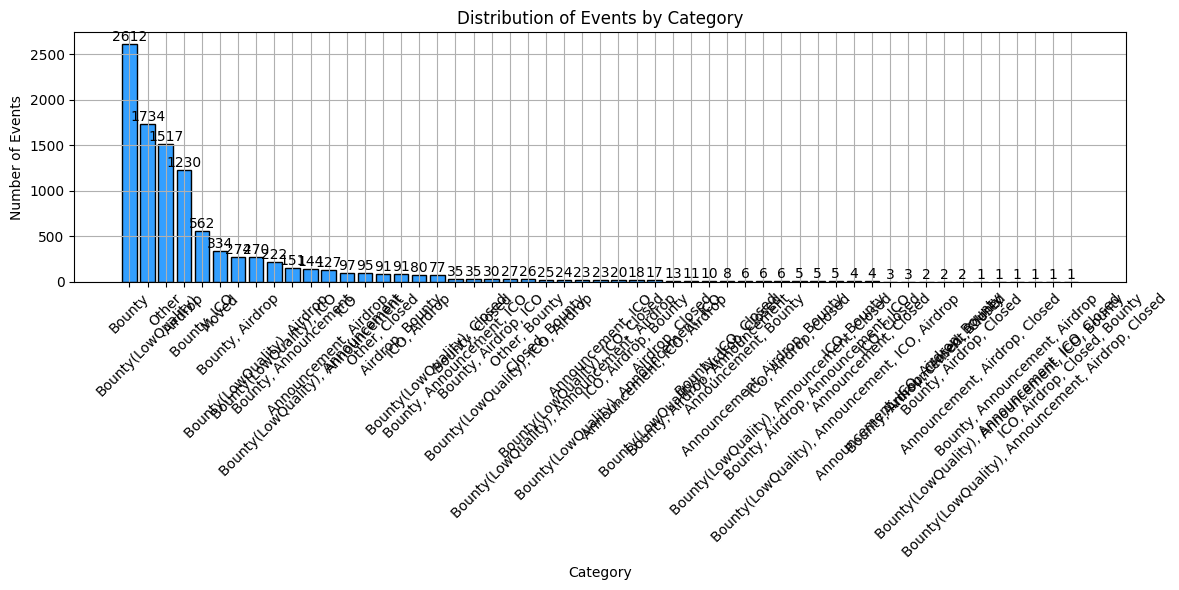

In [4]:
## 1. Distribution of Events by Category
def plot_category_distribution(events_df: DataFrame) -> None:
    """
    Plots the distribution of events by category.

    Args:
        events_df (pd.DataFrame): A dataframe containing event data, where the 'categories' column
                                  contains the event categories.
    
    Returns:
        None: This function does not return any value. It creates a bar chart plot visualizing the 
              distribution of events by category.
    """
    
    events_df['categories'] = events_df['categories'].astype(str)
    category_counts = events_df['categories'].value_counts()
    plot_bar_chart(category_counts.values, category_counts.index, 
                   'Distribution of Events by Category', 'Category', 'Number of Events')


plot_category_distribution(events_df)


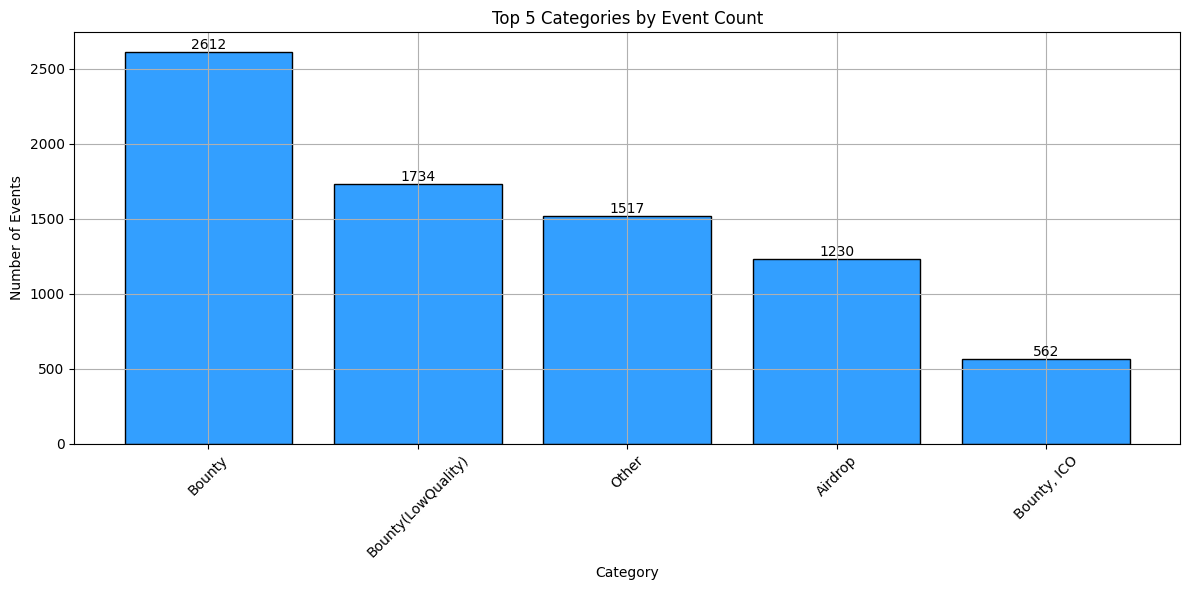

In [5]:
## 2. Top 5 Categories
def plot_top_categories(events_df: DataFrame) -> None:
    """
    Plots the top 5 categories by event count.

    Args:
        events_df (pd.DataFrame): A dataframe containing event data, where the 'categories' column
                                  contains the event categories.

    Returns:
        None: This function does not return any value. It creates a bar chart visualizing the top 
              5 event categories by count.
    """
  
    filtered_events_df = filter_valid_categories(events_df)
    top_categories = filtered_events_df['categories'].value_counts().head(5)
    plot_bar_chart(top_categories.values, top_categories.index, 
                   'Top 5 Categories by Event Count', 'Category', 'Number of Events')


plot_top_categories(events_df)


## Number of consecutive days a bounty event stayed active

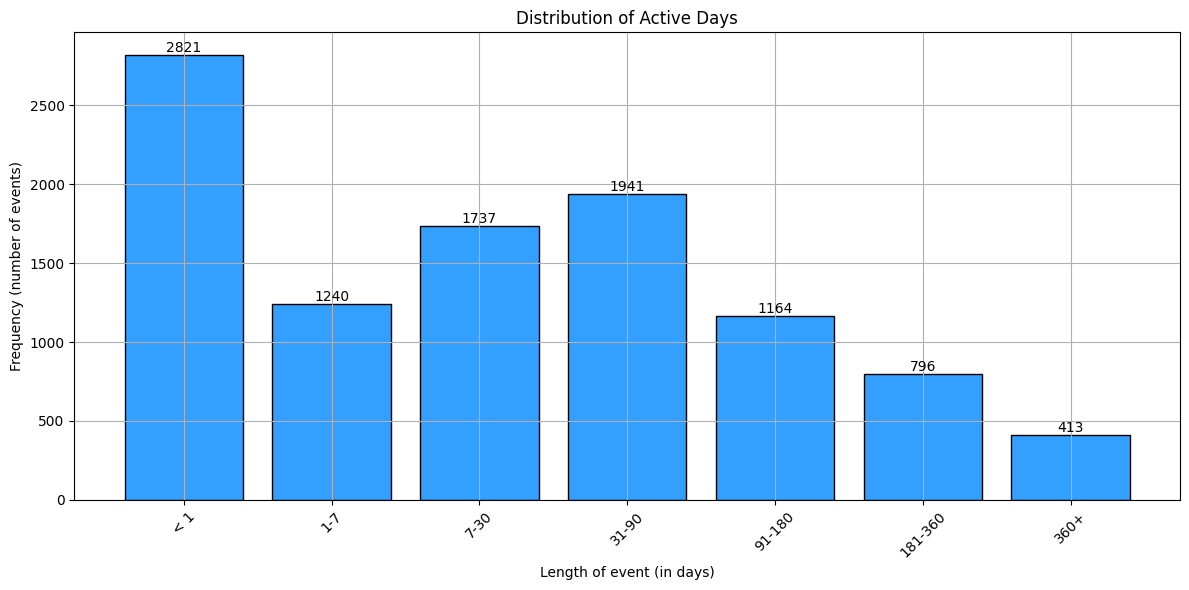

In [6]:
## 3. Number of Active Days for Events
def plot_active_days_distribution(events_df: DataFrame) -> None:
    """
    Plots the distribution of the number of active days for events.

    Args:
        events_df (pd.DataFrame): A dataframe containing event data, where 'post_time' and 'last_post_time' 
                                  represent the start and end dates of the events.

    Returns:
        None: This function does not return any value. It creates a bar chart visualizing the distribution 
              of event active days.
    """
    events_df['thread_id'] = events_df['thread_id'].astype(str)
    events_df['clean_title'] = events_df['clean_title'].astype(str)
    events_df.columns = events_df.columns.str.strip()

    # Parse date columns
    events_df['post_time'] = pd.to_datetime(events_df['post_time'], errors='coerce', dayfirst=True)
    events_df['last_post_time'] = pd.to_datetime(events_df['last_post_time'], errors='coerce', dayfirst=True)

    # Calculate event duration in days
    events_df['active_days'] = (events_df['last_post_time'] - events_df['post_time']).dt.days

    # Filter out invalid active days
    events_df = events_df.dropna(subset=['active_days'])
    events_df = events_df[events_df['active_days'] >= 0]

    # Define custom bins and labels for the histogram
    bins = [0, 1, 7, 30, 90, 180, 360, events_df['active_days'].max() + 1]
    labels = ['< 1', '1-7', '7-30', '31-90', '91-180', '181-360', '360+']

    # Calculate histogram data and plot the distribution
    hist, _ = np.histogram(events_df['active_days'], bins=bins)
    plot_bar_chart(hist, labels, 'Distribution of Active Days', 'Length of event (in days)', 'Frequency (number of events)')

plot_active_days_distribution(events_df)

### By Category

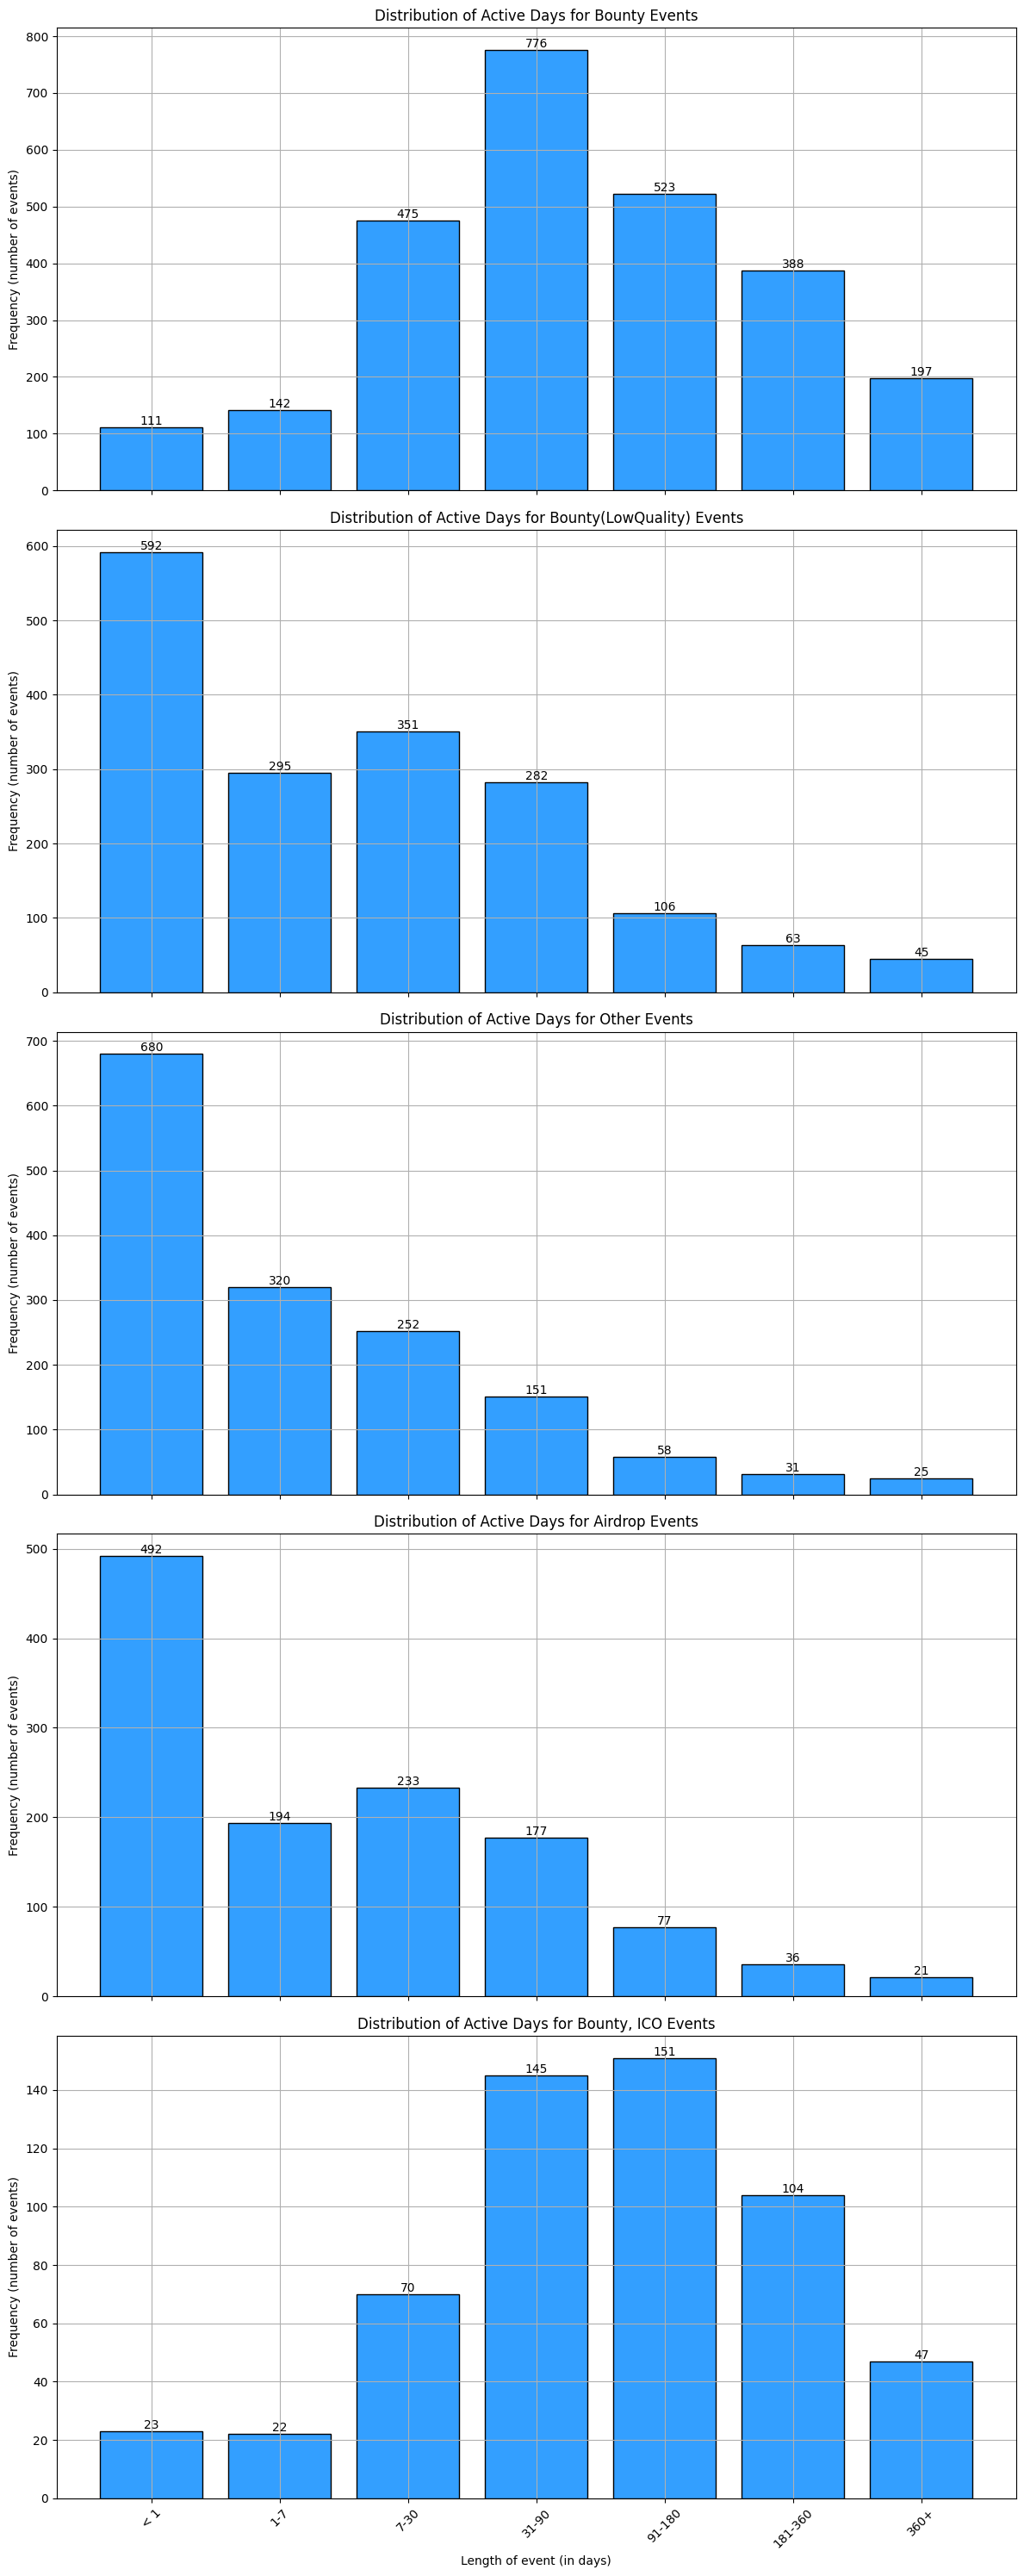

In [7]:
def plot_active_days_distribution(events_df: DataFrame) -> None:
    """
    Plots the distribution of the number of active days for events, both overall and per category.

    Args:
        events_df (pd.DataFrame): DataFrame containing event data, with 'post_time' and 'last_post_time' 
                                  columns representing event start and end times, and a 'categories' column 
                                  for event categories.

    Returns:
        None: This function generates plots of active days distribution.
    """
    events_df['thread_id'] = events_df['thread_id'].astype(str)
    events_df['clean_title'] = events_df['clean_title'].astype(str)
    events_df.columns = events_df.columns.str.strip()

    # Parse date columns and calculate event duration
    events_df['post_time'] = pd.to_datetime(events_df['post_time'], errors='coerce', dayfirst=True)
    events_df['last_post_time'] = pd.to_datetime(events_df['last_post_time'], errors='coerce', dayfirst=True)
    events_df['active_days'] = (events_df['last_post_time'] - events_df['post_time']).dt.days

    # Filter valid active days
    events_df = events_df.dropna(subset=['active_days'])
    events_df = events_df[events_df['active_days'] >= 0]

    # Define custom bins and labels for active days
    bins = [0, 1, 7, 30, 90, 180, 360, events_df['active_days'].max() + 1]
    labels = ['< 1', '1-7', '7-30', '31-90', '91-180', '181-360', '360+']

    # Filter valid categories and get top 5 categories
    filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]
    top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

    # Create subplots for each category's active days distribution
    fig, axes = plt.subplots(len(top_categories), 1, figsize=(12, len(top_categories) * 6), sharex=True)

    for ax, category in zip(axes, top_categories):
        category_df = filtered_events_df[filtered_events_df['categories'] == category]
        hist, _ = np.histogram(category_df['active_days'], bins=bins)

        bar_positions = np.arange(len(hist))
        bars = ax.bar(bar_positions, hist, width=0.8, align='center', color='#339fff', edgecolor='black')

        for bar, height in zip(bars, hist):
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

        ax.set_title(f'Distribution of Active Days for {category} Events')
        ax.set_ylabel('Frequency (number of events)')
        ax.grid(True)

    plt.xticks(bar_positions, labels, rotation=45)
    plt.xlabel('Length of event (in days)')
    plt.tight_layout()
    plt.show()


plot_active_days_distribution(events_df)

## Distribution of Social Media URLs

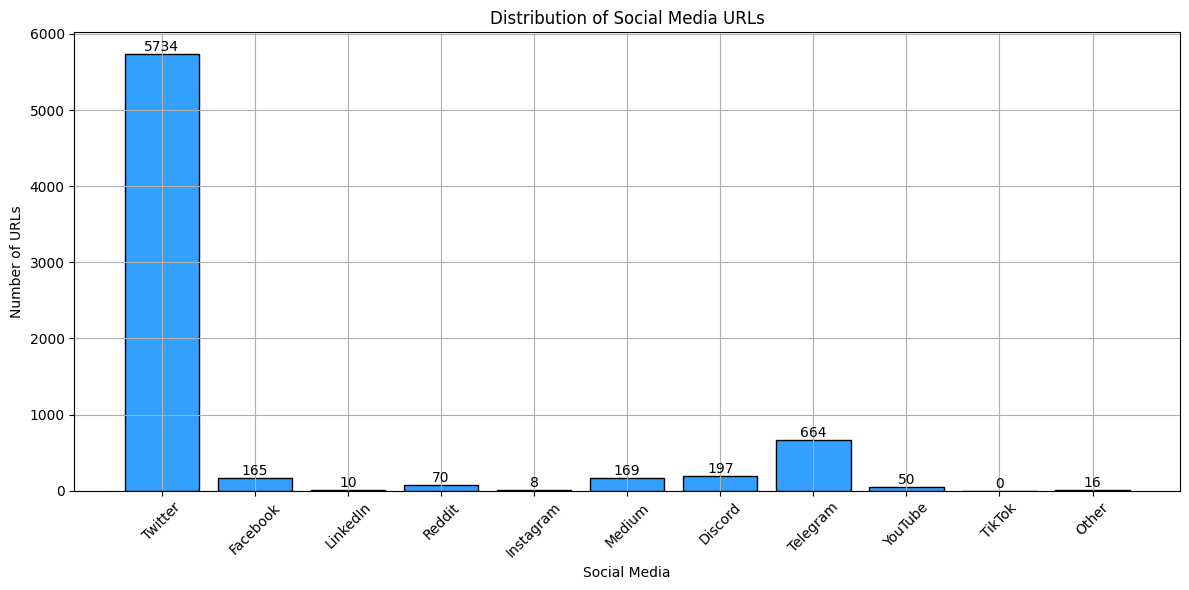

Social Media  Count
0       Twitter   5734
1      Facebook    165
2      LinkedIn     10
3        Reddit     70
4     Instagram      8
5        Medium    169
6       Discord    197
7      Telegram    664
8       YouTube     50
9        TikTok      0
10        Other     16

In [8]:
## 4. Distribution of Social Media URLs

# Define the list of social media keywords 
social_media_keywords = {
    'Twitter': 'twitter',
    'Facebook': 'facebook',
    'LinkedIn': 'linkedin',
    'Reddit': 'reddit',
    'Instagram': 'instagram',
    'Medium': 'medium',
    'Discord': 'discord',
    'Telegram': 't.me',
    'YouTube': 'youtube',
    'TikTok': 'tiktok'
}

def plot_social_media_distribution(events_df: DataFrame) -> DataFrame:
    """
    Plots the distribution of social media URLs in the event data and returns the top 20 results.

    Args:
        events_df (pd.DataFrame): DataFrame containing event data with 'social_media_urls' column.

    Returns:
        pd.DataFrame: DataFrame with the top 20 social media URL counts.
    """
    events_df['social_media_urls'] = events_df['social_media_urls'].astype(str)

    # Get social media counts
    social_media_counts = count_social_media_urls(events_df, social_media_keywords)

    # Convert the dictionary to a DataFrame for easier plotting
    social_media_counts_df = pd.DataFrame(list(social_media_counts.items()), columns=['Social Media', 'Count'])

    # Plot the distribution
    plot_bar_chart(
        social_media_counts_df['Count'],
        social_media_counts_df['Social Media'],
        'Distribution of Social Media URLs',
        'Social Media',
        'Number of URLs'
    )

    return social_media_counts_df.head(20)


plot_social_media_distribution(events_df)

### By Category

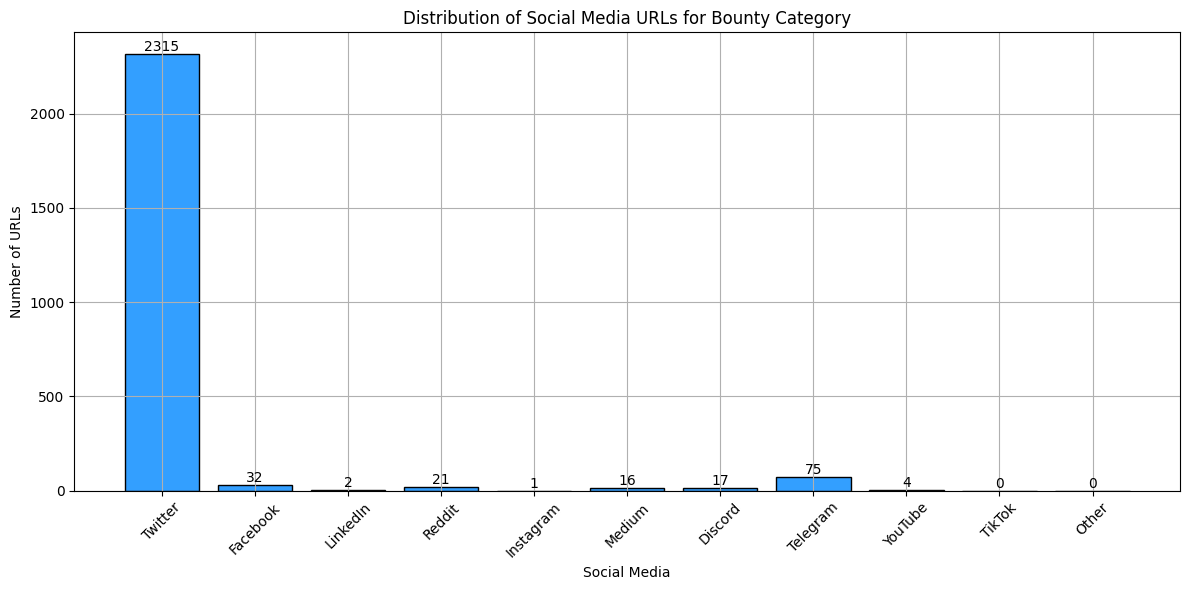

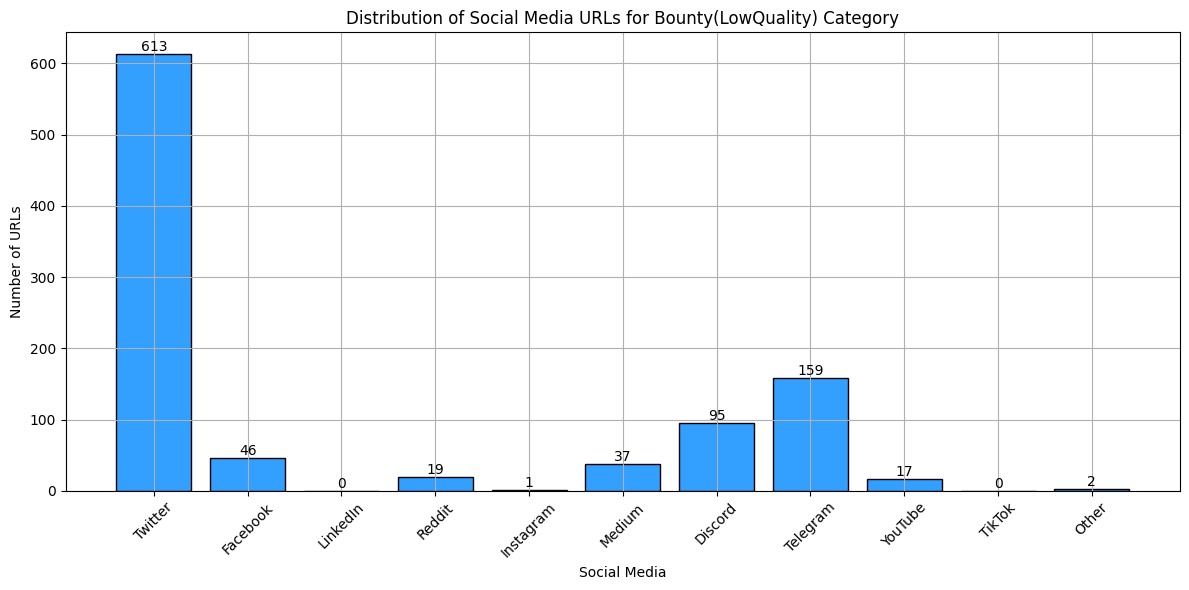

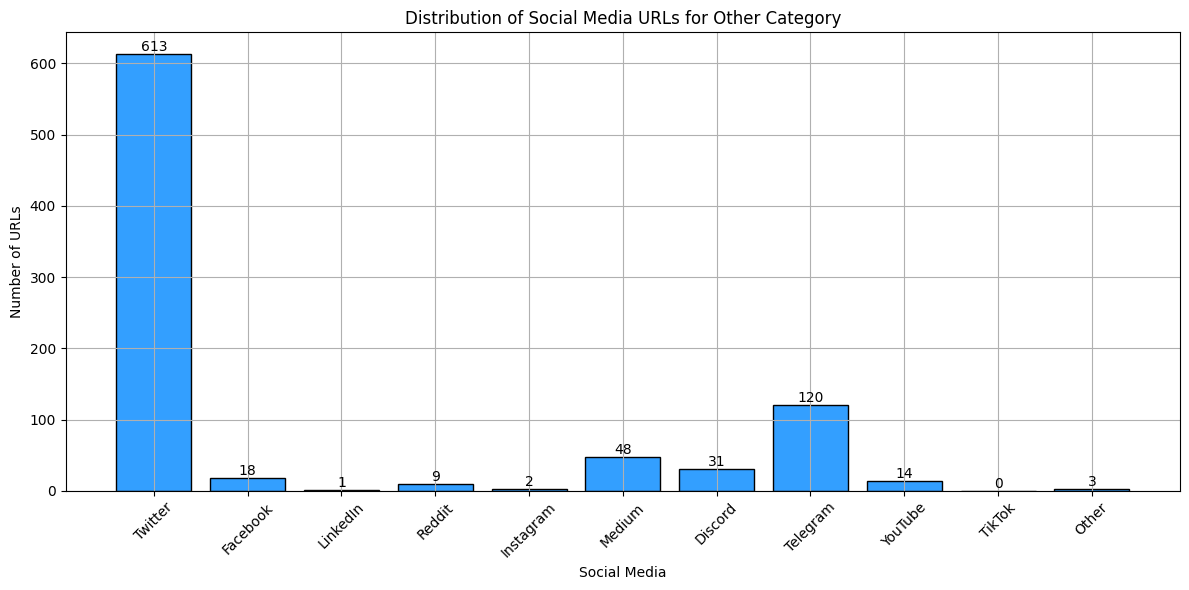

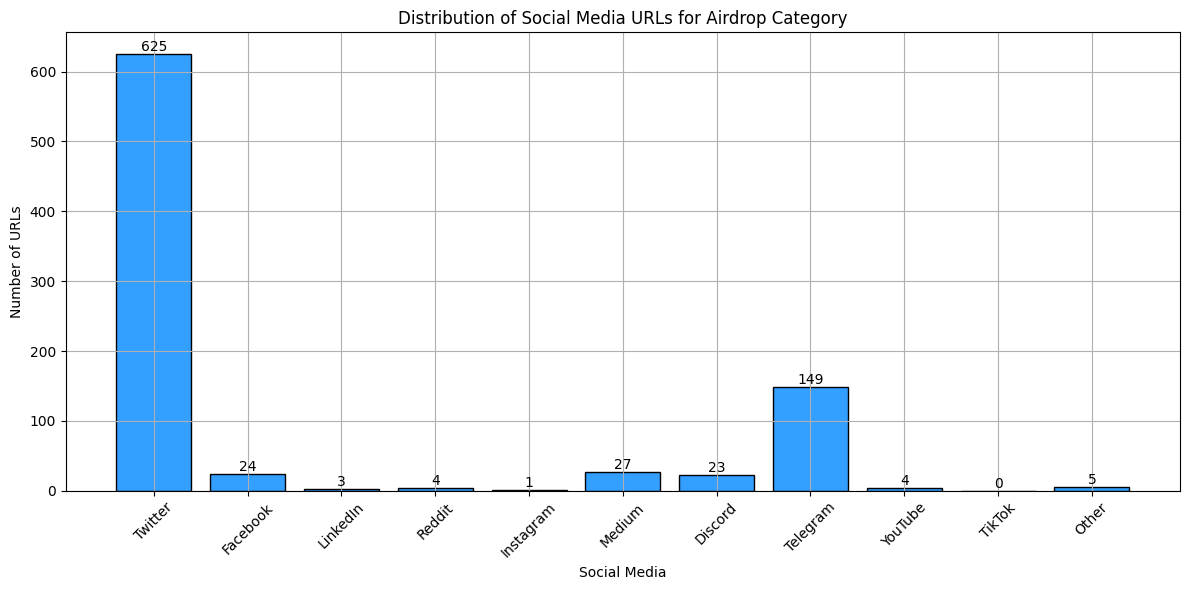

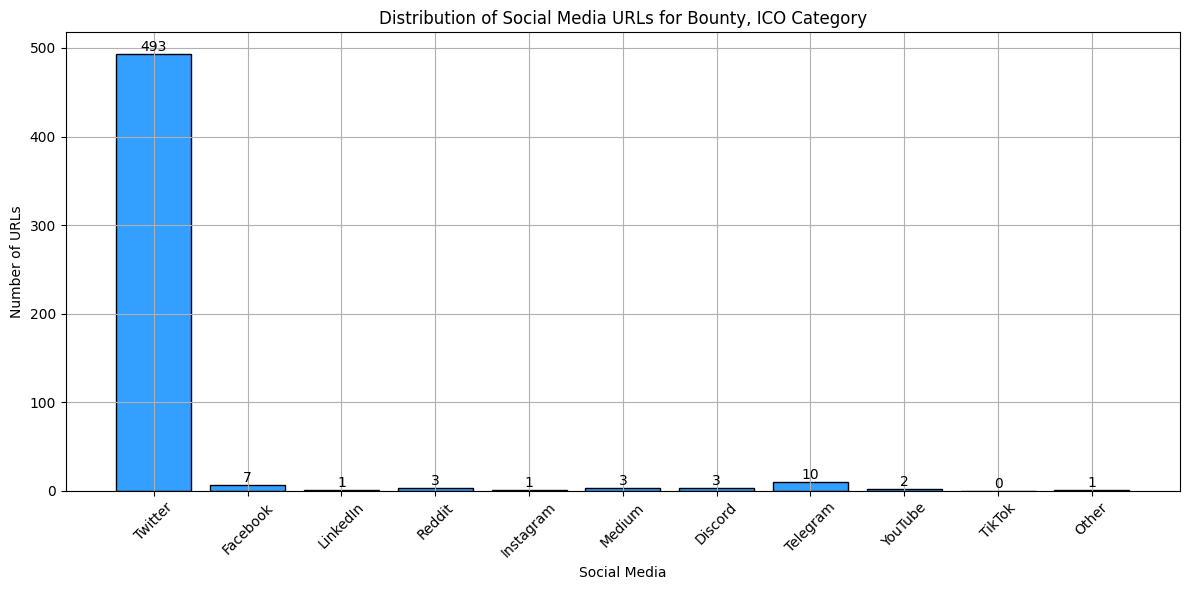

In [9]:
def plot_social_media_distribution_by_category(events_df: DataFrame) -> None:
    """
    Plots the distribution of social media URLs by the top 5 categories in the event data.

    Args:
        events_df (pd.DataFrame): DataFrame containing event data with 'social_media_urls' and 'categories' columns.
    """
    events_df['social_media_urls'] = events_df['social_media_urls'].astype(str)

    # Filter out events containing the word "closed" or "nan" in the 'categories' column
    filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

    # Get the top 5 categories by event count
    top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

    # Plot the distribution for each top category
    for category in top_categories:
        category_df = filtered_events_df[filtered_events_df['categories'] == category]

        # Get social media counts for the current category
        social_media_counts = count_social_media_urls(category_df, social_media_keywords)

        # Convert the dictionary to a DataFrame for easier plotting
        counts_df = pd.DataFrame(list(social_media_counts.items()), columns=['Social Media', 'Count'])

        # Plot the social media distribution for the current category
        plot_bar_chart(
            counts_df['Count'],
            counts_df['Social Media'],
            f'Distribution of Social Media URLs for {category} Category',
            'Social Media',
            'Number of URLs'
        )


plot_social_media_distribution_by_category(events_df)

## Distribution of Reward Allocation Shares

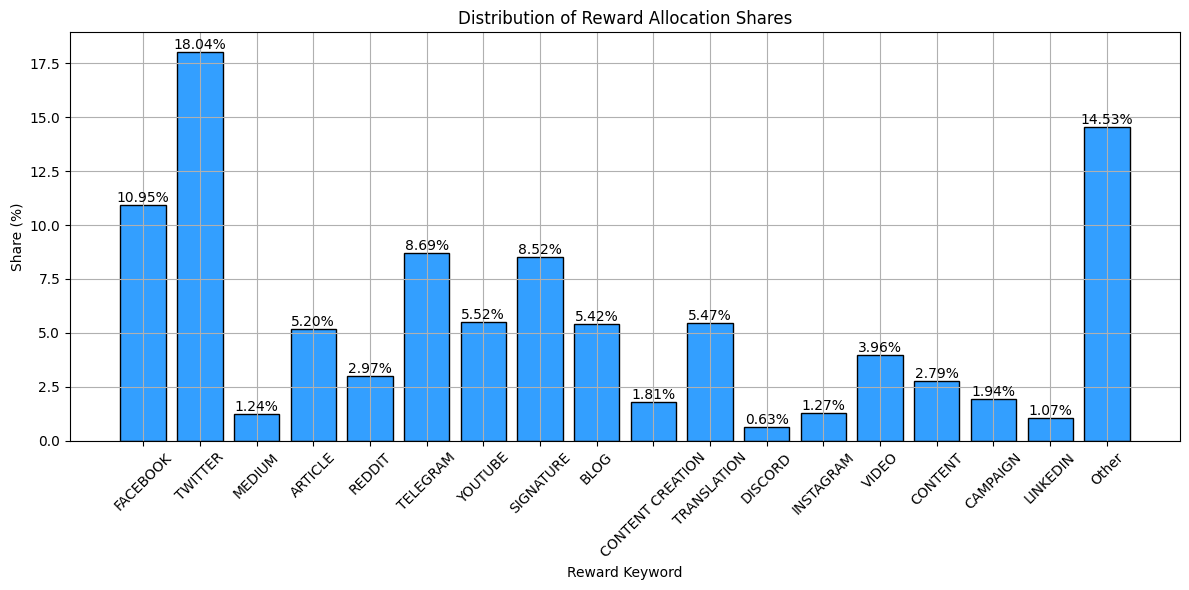

Keywords in 'Other' category:
{'NEWS', 'GAME', 'SLACK', 'WEBSITE', 'COMMUNITY', 'TOKEN', 'KOL', 'ORGANIZATION', 'TEST', 'MODERATION', 'JOIN', 'RESERVE', 'MEDIA', 'WALLET', 'EXCLUSIVE', 'BUGS', 'CONTEST', 'DEVELOPMENT', 'AND', 'EXTRA', 'CREATION', 'NFTS', 'CREATORS', 'AVATAR', 'MANAGEMENT', 'PROGRAM', 'INVESTORS', 'HOLDER', 'FOLLOW', 'SUBSCRIBE', 'WHITEPAPER', 'MEMES', 'MISC', 'BUG', 'MARKETING', 'VK', 'INFLUENCERS', 'US', 'DOCUMENTS', 'TURBO', 'SUBSCRIPTION', 'BOT', 'WARS', 'CAMPAIGNS', 'PLATFORM', 'TIKTOK', 'OWNERSHIP', 'TASKS', 'BOUNTY', 'SUPPORT', 'MANAGMENT', 'REVIEW', 'GROUP', 'COINGECKO', 'DESIGN', 'POST', 'HUNT', 'VKONTAKTE', 'SURPRISE', 'MEETUP', 'NEWSLETTER', 'FORUM', 'GIF', 'GROWTH', 'SHORT', 'DAILY', 'INFOGRAPHIC', 'STEEMIT', 'TEAM', 'MULTIMEDIA', 'OF', 'STAKING', 'REGISTRATION', 'ALTCOINSTALKS', 'AMBASSADOR', 'OFFER', 'ENGAGEMENT', 'ICO', 'DISCRETIONARY', 'INVITE', 'APP', 'MEME', 'SHILL', 'STEEM', 'NETWORK', 'TESTERS', 'SHORTS', 'SELFIE', 'ARTWORK', 'SIGNUP', 'AUDIT', 'HACK

Reward Keyword      Share
0           FACEBOOK  10.945079
1            TWITTER  18.037385
2             MEDIUM   1.238131
3            ARTICLE   5.195989
4             REDDIT   2.973596
5           TELEGRAM   8.694802
6            YOUTUBE   5.521024
7          SIGNATURE   8.515845
8               BLOG   5.420933
9   CONTENT CREATION   1.809336
10       TRANSLATION   5.471499
11           DISCORD   0.631343
12         INSTAGRAM   1.265183
13             VIDEO   3.955777
14           CONTENT   2.787356
15          CAMPAIGN   1.935854
16          LINKEDIN   1.066874
17             Other  14.533995

In [4]:
## 5.  Distribution of Reward Allocation Shares

# Define the list of reward allocation keywords
reward_keywords = [
    'FACEBOOK', 'TWITTER', 'MEDIUM', 'ARTICLE', 'REDDIT', 
    'TELEGRAM', 'YOUTUBE', 'SIGNATURE', 'BLOG', 'CONTENT CREATION', 
    'TRANSLATION', 'DISCORD', 'INSTAGRAM', 'VIDEO', 
    'CONTENT', 'CAMPAIGN',  'LINKEDIN'
]

def plot_reward_allocation_distribution(events_df: DataFrame) -> DataFrame:
    """
    Plots the distribution of reward allocation shares based on predefined reward keywords.

    Args:
        events_df (pd.DataFrame): DataFrame containing event data with 'reward_allocation' column.

    Returns:
        pd.DataFrame: DataFrame with the calculated reward allocation share for each keyword.
    """
    events_df['reward_allocation'] = events_df['reward_allocation'].astype(str)

    # Get the reward allocation sums and other keywords
    reward_allocation_sums, other_keywords_list = count_reward_allocations(events_df, reward_keywords)

    # Calculate percentage shares of reward allocations
    reward_allocation_share = calculate_share(reward_allocation_sums)

    # Convert to DataFrame for plotting
    reward_allocation_share_df = pd.DataFrame(list(reward_allocation_share.items()), columns=['Reward Keyword', 'Share'])

    # Plot the distribution of reward allocation shares
    plot_bar_chart_percent(
        reward_allocation_share_df['Share'],
        reward_allocation_share_df['Reward Keyword'],
        'Distribution of Reward Allocation Shares',
        'Reward Keyword',
        'Share (%)'
    )

    # Display the unique keywords in the 'Other' category
    print("Keywords in 'Other' category:")
    print(set(other_keywords_list))

    # Find the most common keyword in the 'Other' category
    from collections import Counter
    most_common_other = Counter(other_keywords_list).most_common(1)
    print(f"Most common keyword in 'Other' category and its count: {most_common_other}")

    return reward_allocation_share_df


plot_reward_allocation_distribution(events_df)


### By Category

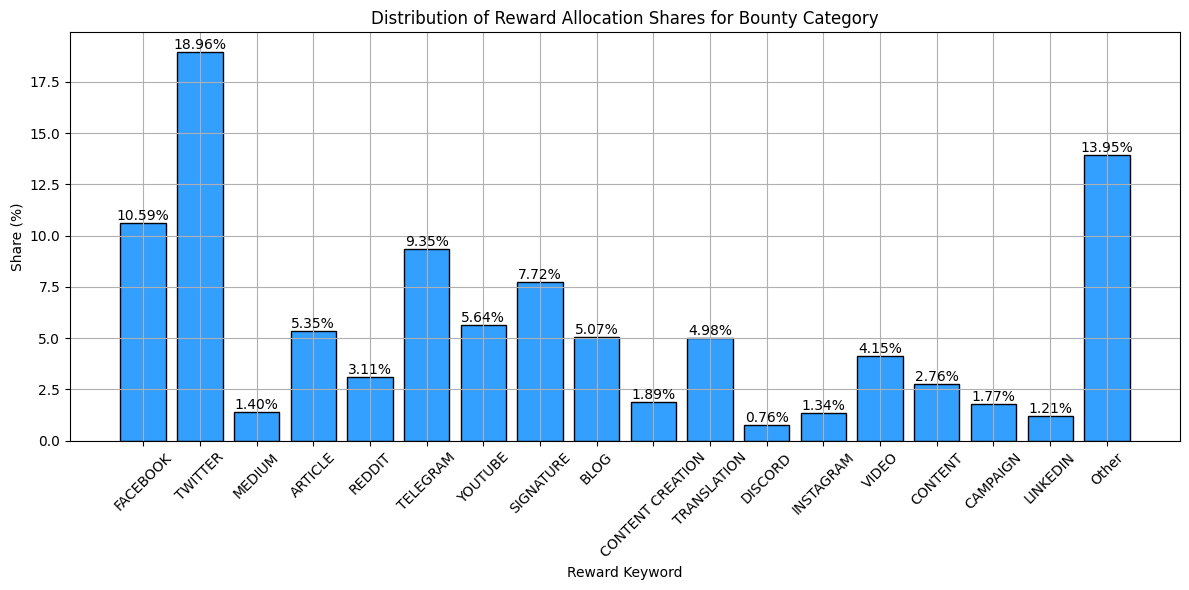

Keywords in reword column for Bounty category:
{'NEWS', 'GAME', 'SLACK', 'WEBSITE', 'COMMUNITY', 'TOKEN', 'KOL', 'ORGANIZATION', 'TEST', 'MODERATION', 'JOIN', 'RESERVE', 'MEDIA', 'WALLET', 'EXCLUSIVE', 'BUGS', 'CONTEST', 'DEVELOPMENT', 'AND', 'EXTRA', 'CREATION', 'NFTS', 'CREATORS', 'AVATAR', 'MANAGEMENT', 'PROGRAM', 'INVESTORS', 'HOLDER', 'FOLLOW', 'SUBSCRIBE', 'MEMES', 'MISC', 'BUG', 'MARKETING', 'VK', 'INFLUENCERS', 'US', 'TURBO', 'SUBSCRIPTION', 'CAMPAIGNS', 'PLATFORM', 'TIKTOK', 'OWNERSHIP', 'TASKS', 'BOUNTY', 'SUPPORT', 'MANAGMENT', 'REVIEW', 'GROUP', 'COINGECKO', 'DESIGN', 'POST', 'HUNT', 'VKONTAKTE', 'SURPRISE', 'NEWSLETTER', 'FORUM', 'GIF', 'GROWTH', 'SHORT', 'DAILY', 'INFOGRAPHIC', 'STEEMIT', 'TEAM', 'MULTIMEDIA', 'OF', 'STAKING', 'REGISTRATION', 'ALTCOINSTALKS', 'AMBASSADOR', 'OFFER', 'ENGAGEMENT', 'ICO', 'INVITE', 'APP', 'MEME', 'SHILL', 'STEEM', 'NETWORK', 'TESTERS', 'SHORTS', 'SELFIE', 'ARTWORK', 'SIGNUP', 'AUDIT', 'HACKING', 'AIRDROP', 'REFERRAL', 'QUIZ', 'NETWORKS', 'PR

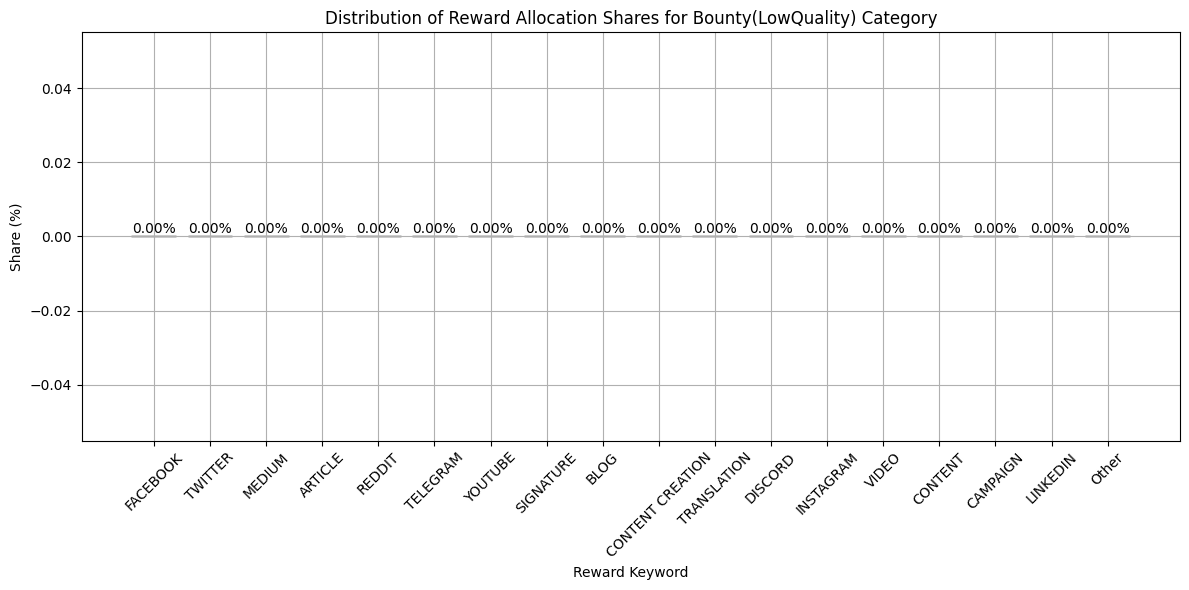

Keywords in reword column for Bounty(LowQuality) category:
set()
Most common keyword in reword column for Bounty(LowQuality) category and its count: []


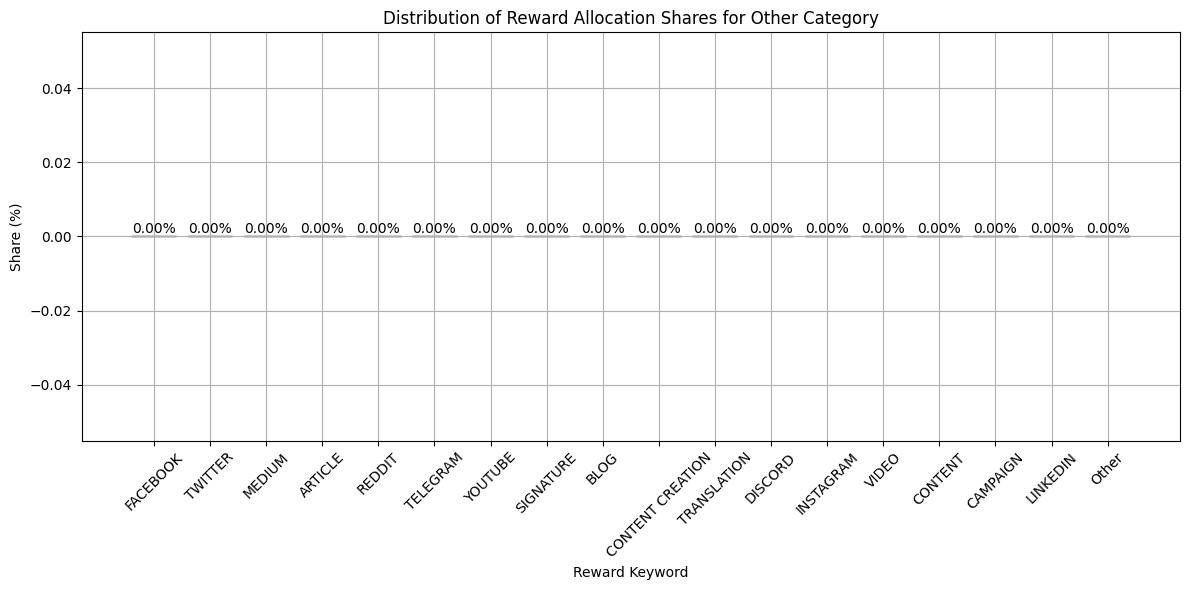

Keywords in reword column for Other category:
set()
Most common keyword in reword column for Other category and its count: []


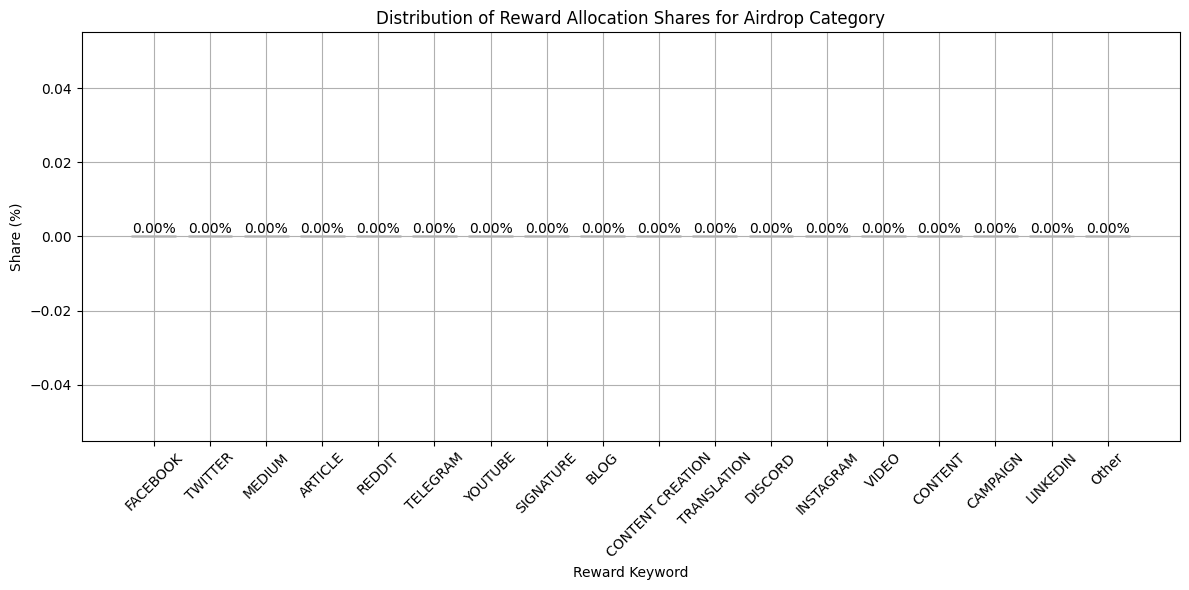

Keywords in reword column for Airdrop category:
set()
Most common keyword in reword column for Airdrop category and its count: []


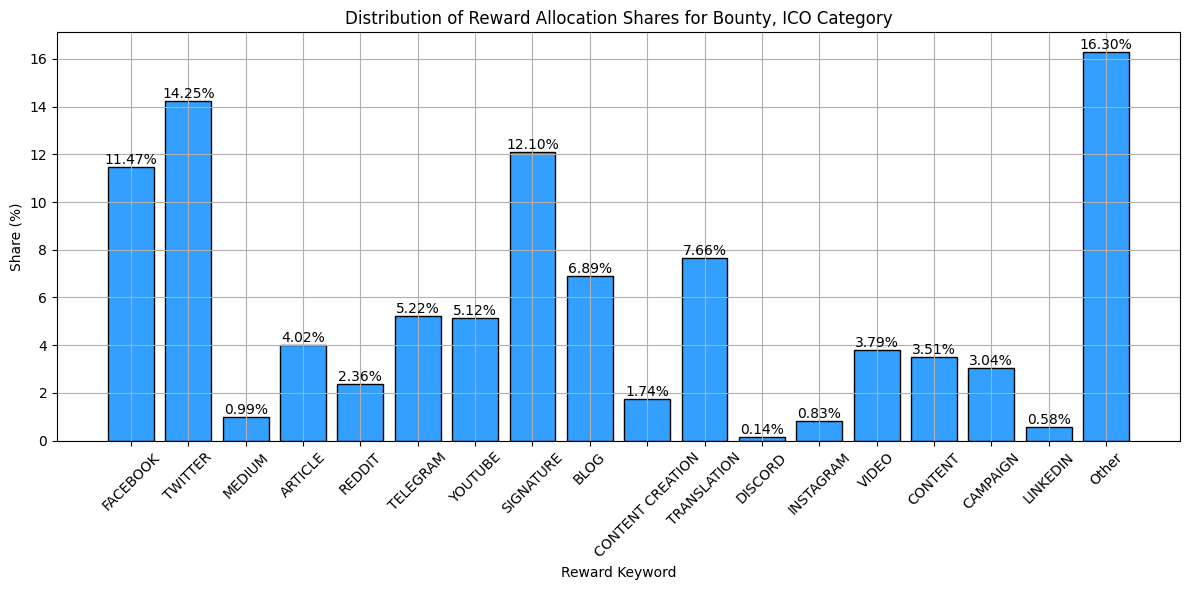

Keywords in reword column for Bounty, ICO category:
{'STEEMIT', 'NEWS', 'SLACK', 'DOCUMENTS', 'COMMUNITY', 'REFERRAL', 'SUBSCRIPTION', 'OF', 'AMBASSADOR', 'TIKTOK', 'ENGAGEMENT', 'MODERATION', 'BONUS', 'RESERVE', 'ICO', 'MEDIA', 'APP', 'FUND', 'EXCLUSIVE', 'CONTEST', 'DEVELOPMENT', 'AND', 'BOUNTY', 'OTHER', 'STEEM', 'SUPPORT', 'EXTRA', 'CREATION', 'REVIEW', 'PUBLICATION', 'SEARCH', 'NETWORK', 'AVATAR', 'SPECIAL', 'GROUP', 'BITCOINTALK', 'MANAGEMENT', 'ARTWORK', 'PROGRAM', 'POST', 'FOLLOW', 'HUNT', 'VKONTAKTE', 'CREATIVE', 'DOWNLOAD', 'SUBSCRIBE', 'WHITEPAPER', 'MISCELLANEOUS', 'MISC', 'SOCIAL', 'BUG', 'NEWSLETTER', 'AIRDROP', 'VK', 'INFLUENCERS', 'GRAPHICS'}
Most common keyword in reword column for Bounty, ICO category and its count: [('MEDIA', 26)]


In [9]:
def plot_reward_allocation_distribution_by_category(events_df: DataFrame) -> None:
    """
    Plots the reward allocation distribution for the top 5 event categories based on reward keywords.

    Args:
        events_df (pd.DataFrame): DataFrame containing event data with 'reward_allocation' and 'categories' columns.

    Returns:
        None
    """
    events_df['reward_allocation'] = events_df['reward_allocation'].astype(str)

    # Filter out events containing "closed" or "nan" in the 'categories' column
    filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

    # Get the top 5 categories
    top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

    # Iterate through each category and plot the reward allocation distribution
    for category in top_categories:
        category_df = filtered_events_df[filtered_events_df['categories'] == category]

        # Get reward allocation sums and other keywords for the current category
        category_reward_sums, category_other_keywords = count_reward_allocations(category_df, reward_keywords)

        # Calculate percentage shares and skip categories with zero reward allocations
        category_reward_share = calculate_share(category_reward_sums)
        if not category_reward_share:
            print(f"Skipping category '{category}' due to zero reward allocations.")
            continue

        # Convert to DataFrame for plotting
        share_df = pd.DataFrame(list(category_reward_share.items()), columns=['Reward Keyword', 'Share'])

        # Plot the distribution of reward allocations
        plot_bar_chart_percent(
            share_df['Share'],
            share_df['Reward Keyword'],
            f'Distribution of Reward Allocation Shares for {category} Category',
            'Reward Keyword',
            'Share (%)'
        )

        # Display additional information
        print(f"Keywords in reward column for {category} category:")
        print(set(category_other_keywords))

        # Find the most common 'Other' keyword for this category
        most_common_other = Counter(category_other_keywords).most_common(1)
        print(f"Most common keyword in reward column for {category} category and its count: {most_common_other}")


plot_reward_allocation_distribution_by_category(events_df)

# Find Common Combinations

In [ ]:
# Ensure columns are treated as string
events_df['clean_title'] = events_df['clean_title'].astype(str)
events_df['general_rules'] = events_df['general_rules'].astype(str)
events_df['post_tex'] = events_df['post_tex'].astype(str)


# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['general_rules_tokens'] = events_df['general_rules'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Remove rows where the preprocessed text columns are empty
events_df = events_df[events_df['clean_title_tokens'].str.strip() != '']
events_df = events_df[events_df['general_rules_tokens'].str.strip() != '']
events_df = events_df[events_df['post_tex_tokens'].str.strip() != '']


# Flatten the list of tokens and count frequencies for clean_title
all_clean_title_tokens = [token for sublist in events_df['clean_title_tokens'] for token in sublist]
clean_title_word_freq = Counter(all_clean_title_tokens)

# Get the most common words in clean_title
most_common_clean_title_words = clean_title_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in clean_title:")
print(most_common_clean_title_words)

# Flatten the list of tokens and count frequencies for general_rules
all_general_rules_tokens = [token for sublist in events_df['general_rules_tokens'] for token in sublist]
general_rules_word_freq = Counter(all_general_rules_tokens)

# Get the most common words in general_rules
most_common_general_rules_words = general_rules_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in general_rules:")
print(most_common_general_rules_words)

# Flatten the list of tokens and count frequencies for post_tex
all_post_tex_tokens = [token for sublist in events_df['post_tex_tokens'] for token in sublist]
post_tex_word_freq = Counter(all_post_tex_tokens)

# Get the most common words in post_tex
most_common_post_tex_words = post_tex_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in post_tex:")
print(most_common_post_tex_words)

# Find bigrams and trigrams for clean_title
all_clean_title_bigrams = [bigram for sublist in events_df['clean_title_tokens'] for bigram in bigrams(sublist)]
all_clean_title_trigrams = [trigram for sublist in events_df['clean_title_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for clean_title
clean_title_bigram_freq = Counter(all_clean_title_bigrams)
clean_title_trigram_freq = Counter(all_clean_title_trigrams)

# Get the most common bigrams and trigrams in clean_title
most_common_clean_title_bigrams = clean_title_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_clean_title_trigrams = clean_title_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in title:")
print(most_common_clean_title_bigrams)
print("Most Common Trigrams in title:")
print(most_common_clean_title_trigrams)


# Find bigrams and trigrams for general_rules
all_general_rules_bigrams = [bigram for sublist in events_df['general_rules_tokens'] for bigram in bigrams(sublist)]
all_general_rules_trigrams = [trigram for sublist in events_df['general_rules_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for general_rules
general_rules_bigram_freq = Counter(all_general_rules_bigrams)
general_rules_trigram_freq = Counter(all_general_rules_trigrams)

# Get the most common bigrams and trigrams in general_rules
most_common_general_rules_bigrams = general_rules_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_general_rules_trigrams = general_rules_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in general_rules:")
print(most_common_general_rules_bigrams)
print("Most Common Trigrams in general_rules:")
print(most_common_general_rules_trigrams)

# Find bigrams and trigrams for post_tex
all_post_tex_bigrams = [bigram for sublist in events_df['post_tex_tokens'] for bigram in bigrams(sublist)]
all_post_tex_trigrams = [trigram for sublist in events_df['post_tex_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for post_tex
post_tex_bigram_freq = Counter(all_post_tex_bigrams)
post_tex_trigram_freq = Counter(all_post_tex_trigrams)

# Get the most common bigrams and trigrams in post_tex
most_common_post_tex_bigrams = post_tex_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_post_tex_trigrams = post_tex_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in post_tex:")
print(most_common_post_tex_bigrams)
print("Most Common Trigrams in post_tex:")
print(most_common_post_tex_trigrams)




Most Common Words in clean_title:
[('bounty', 2845), ('airdrop', 1525), ('campaign', 1245), ('token', 1060), ('platform', 613), ('reward', 605), ('coin', 568), ('exchange', 524), ('free', 522), ('program', 494), ('get', 475), ('worth', 474), ('pool', 454), ('earn', 443), ('k', 430), ('first', 367), ('twitter', 360), ('new', 355), ('telegram', 347), ('network', 327)]
Most Common Words in general_rules:
[('nan', 10673), ('bounty', 7021), ('campaign', 5776), ('must', 3836), ('telegram', 2384), ('week', 2370), ('post', 2092), ('join', 2022), ('group', 1819), ('thread', 1467), ('right', 1324), ('least', 1307), ('twitter', 1303), ('per', 1296), ('form', 1271), ('please', 1224), ('video', 1191), ('end', 1183), ('account', 1109), ('make', 1087)]
Most Common Words in post_tex:
[('bounty', 56356), ('must', 50644), ('campaign', 38157), ('per', 34047), ('telegram', 31584), ('post', 27343), ('twitter', 23548), ('week', 21157), ('least', 20909), ('link', 19029), ('join', 18480), ('official', 16039),

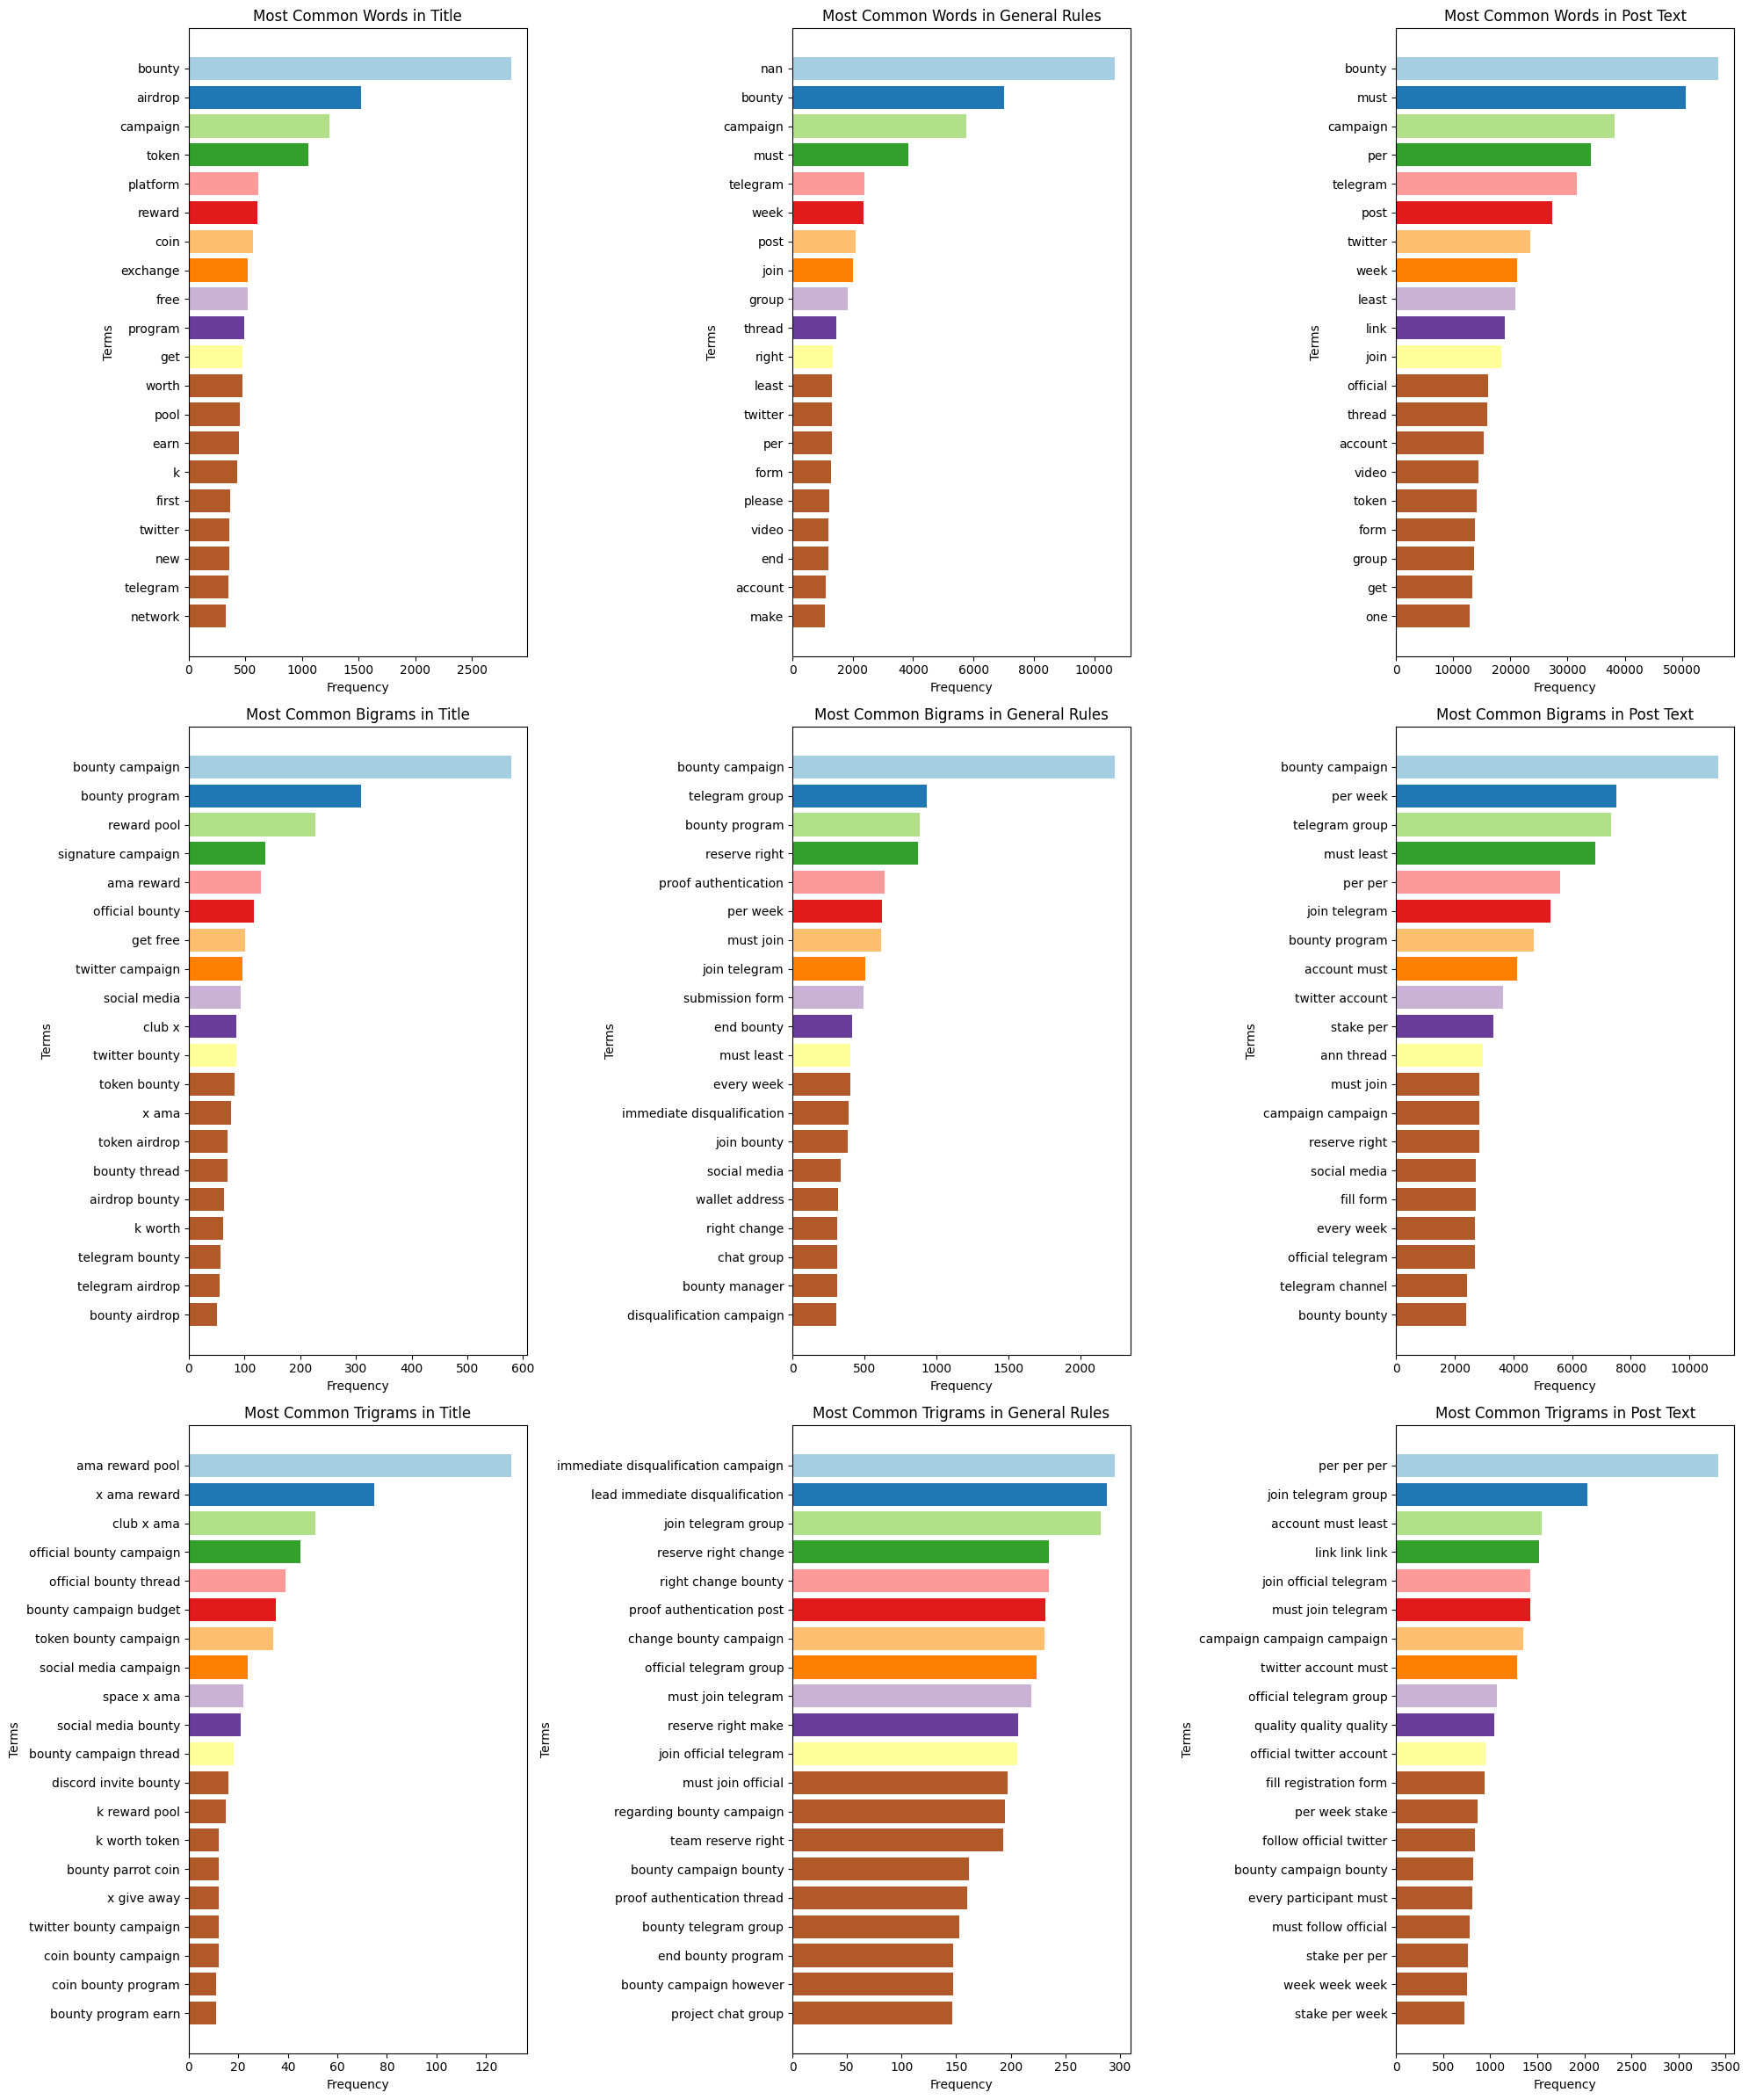

In [ ]:
# Function to plot frequency distribution
def plot_freq_distribution(ax, freq_dist, title):
    labels, values = zip(*freq_dist)
    labels = [' '.join(label) if isinstance(label, tuple) else label for label in labels]  # Convert tuples to strings
    ax.barh(labels, values, color=plt.cm.Paired(range(len(freq_dist))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Terms')

# Create subplots for most common words, bigrams, and trigrams in separate rows
fig, axes = plt.subplots(3, 3, figsize=(20, 24))

# Plot most common words
plot_freq_distribution(axes[0, 0], most_common_clean_title_words, 'Most Common Words in Title')
plot_freq_distribution(axes[0, 1], most_common_general_rules_words, 'Most Common Words in General Rules')
plot_freq_distribution(axes[0, 2], most_common_post_tex_words, 'Most Common Words in Post Text')

# Plot most common bigrams
plot_freq_distribution(axes[1, 0], most_common_clean_title_bigrams, 'Most Common Bigrams in Title')
plot_freq_distribution(axes[1, 1], most_common_general_rules_bigrams, 'Most Common Bigrams in General Rules')
plot_freq_distribution(axes[1, 2], most_common_post_tex_bigrams, 'Most Common Bigrams in Post Text')

# Plot most common trigrams
plot_freq_distribution(axes[2, 0], most_common_clean_title_trigrams, 'Most Common Trigrams in Title')
plot_freq_distribution(axes[2, 1], most_common_general_rules_trigrams, 'Most Common Trigrams in General Rules')
plot_freq_distribution(axes[2, 2], most_common_post_tex_trigrams, 'Most Common Trigrams in Post Text')

# Adjust layout
plt.tight_layout()
plt.show()

### By Category

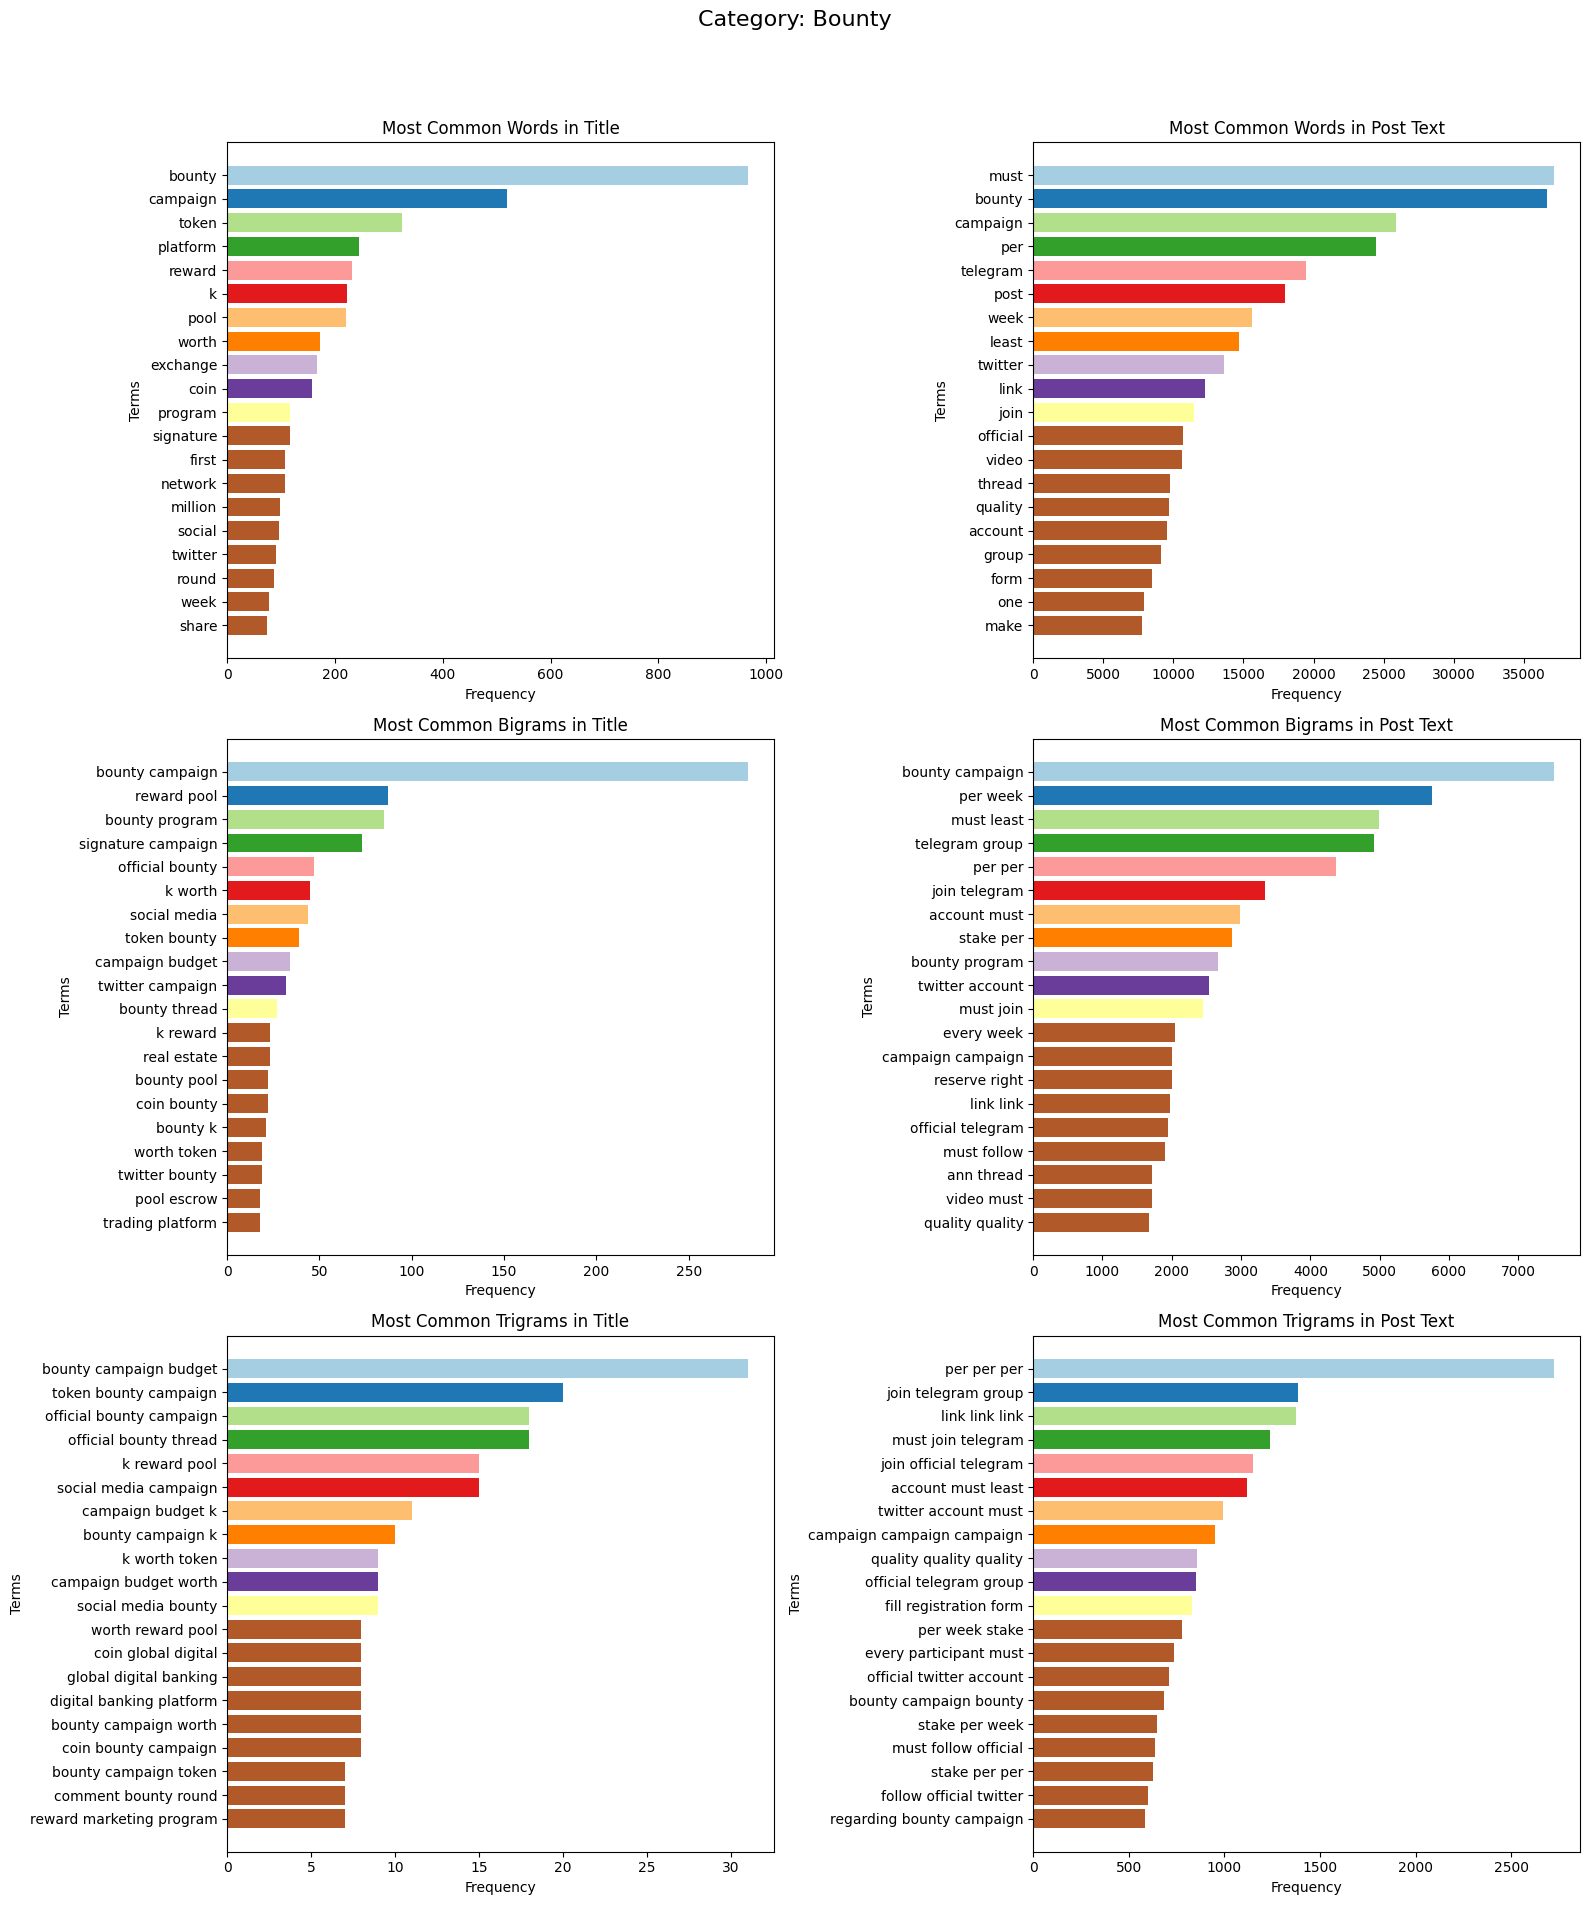

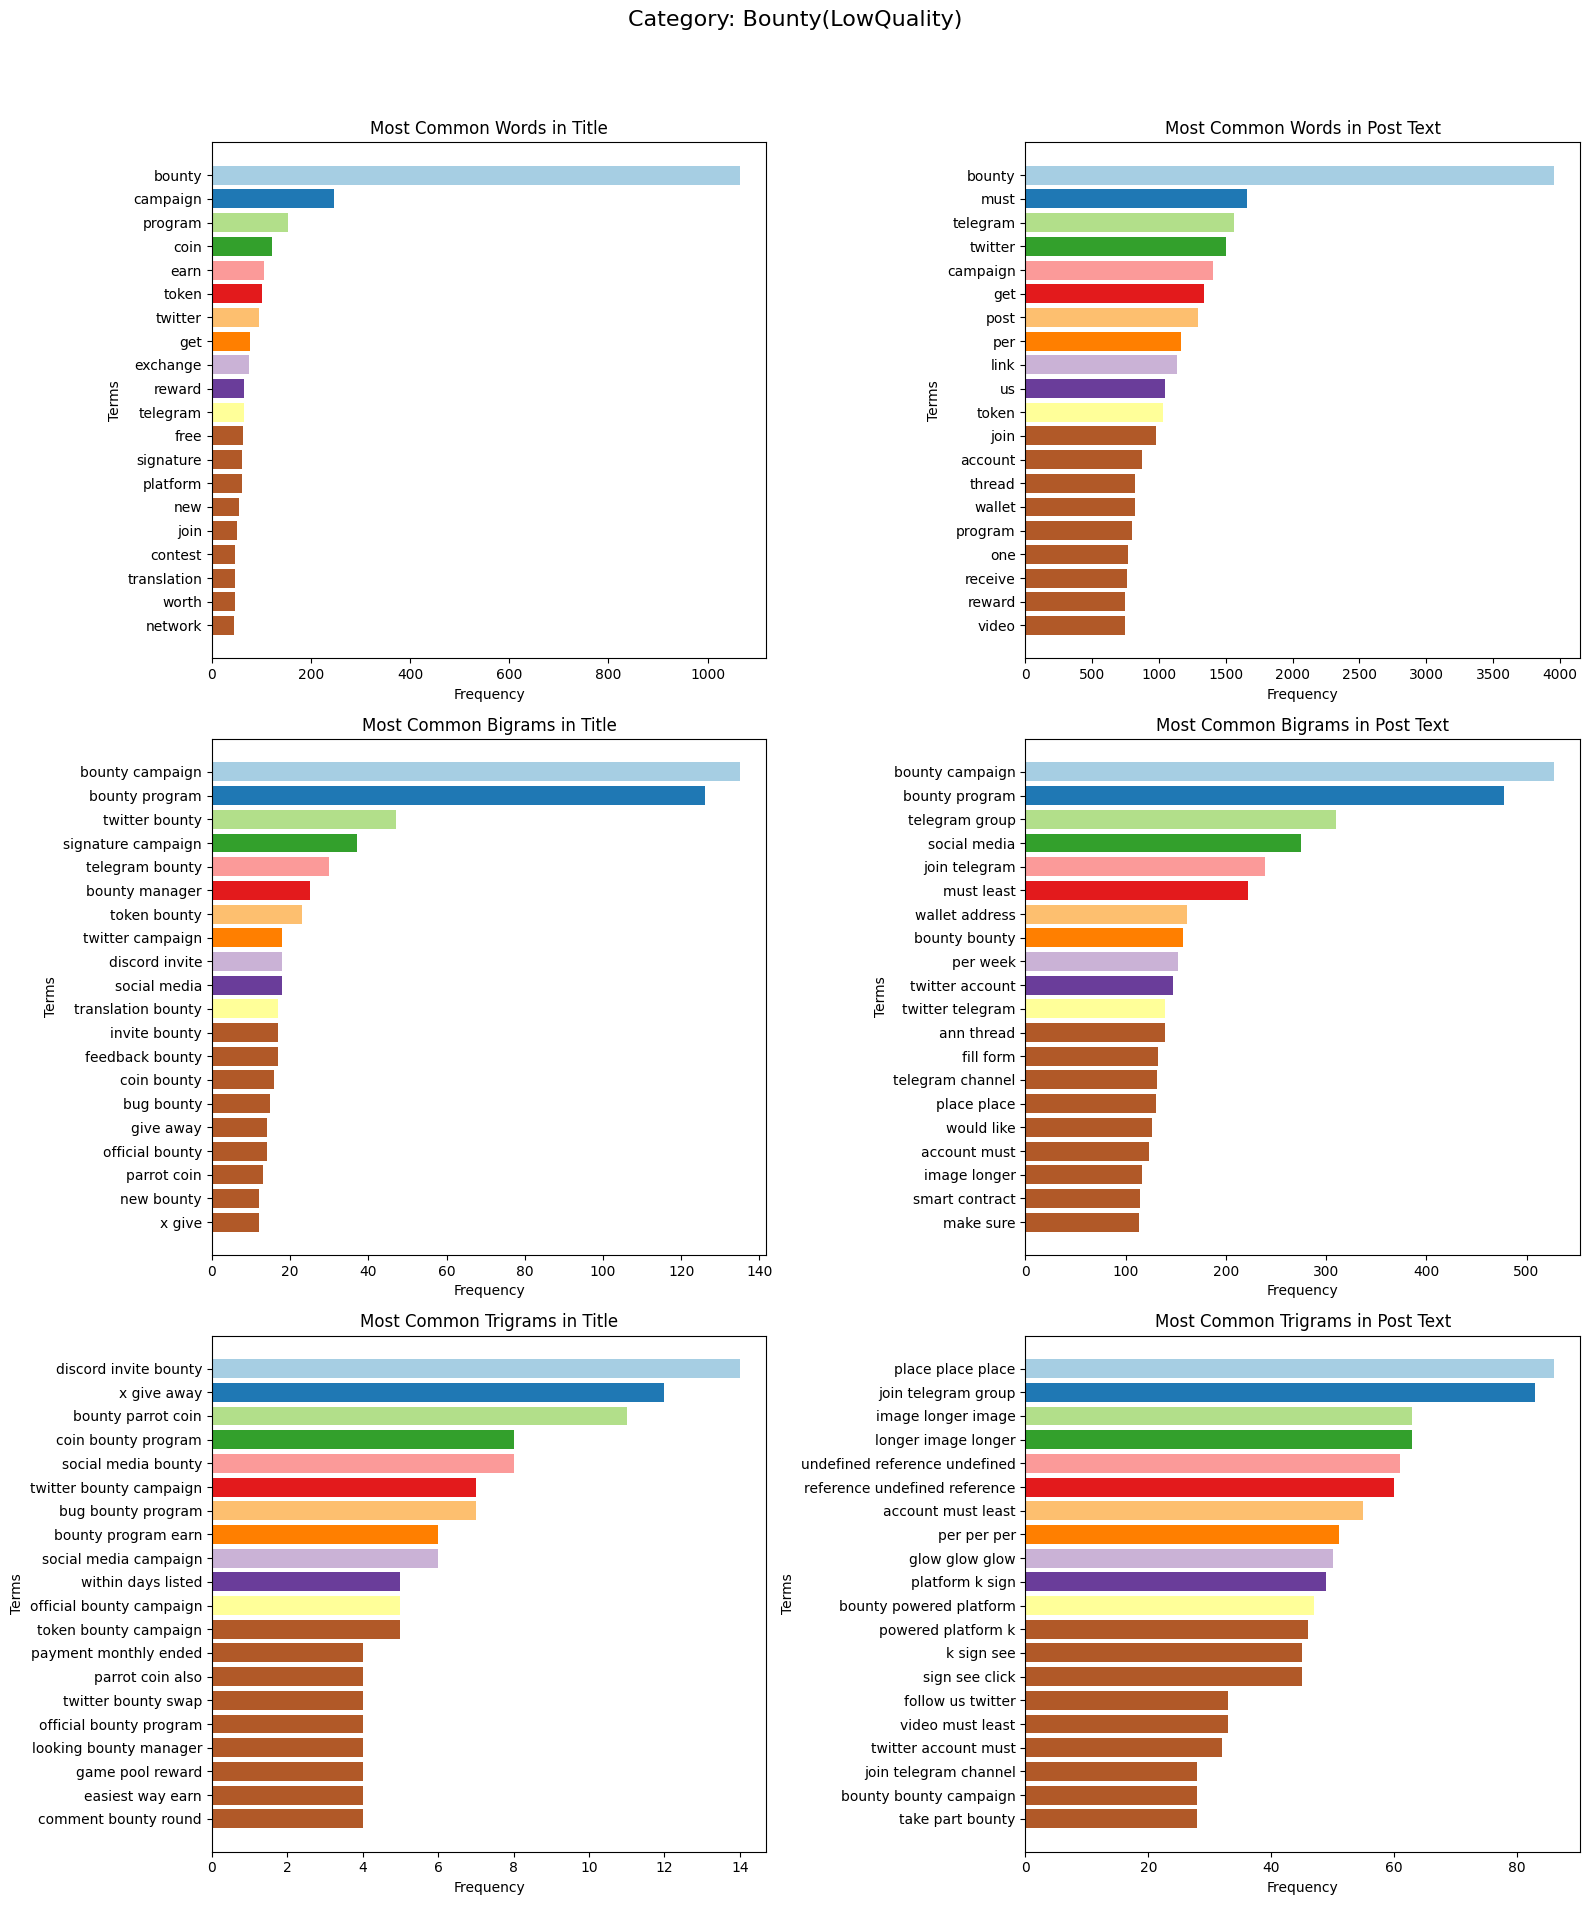

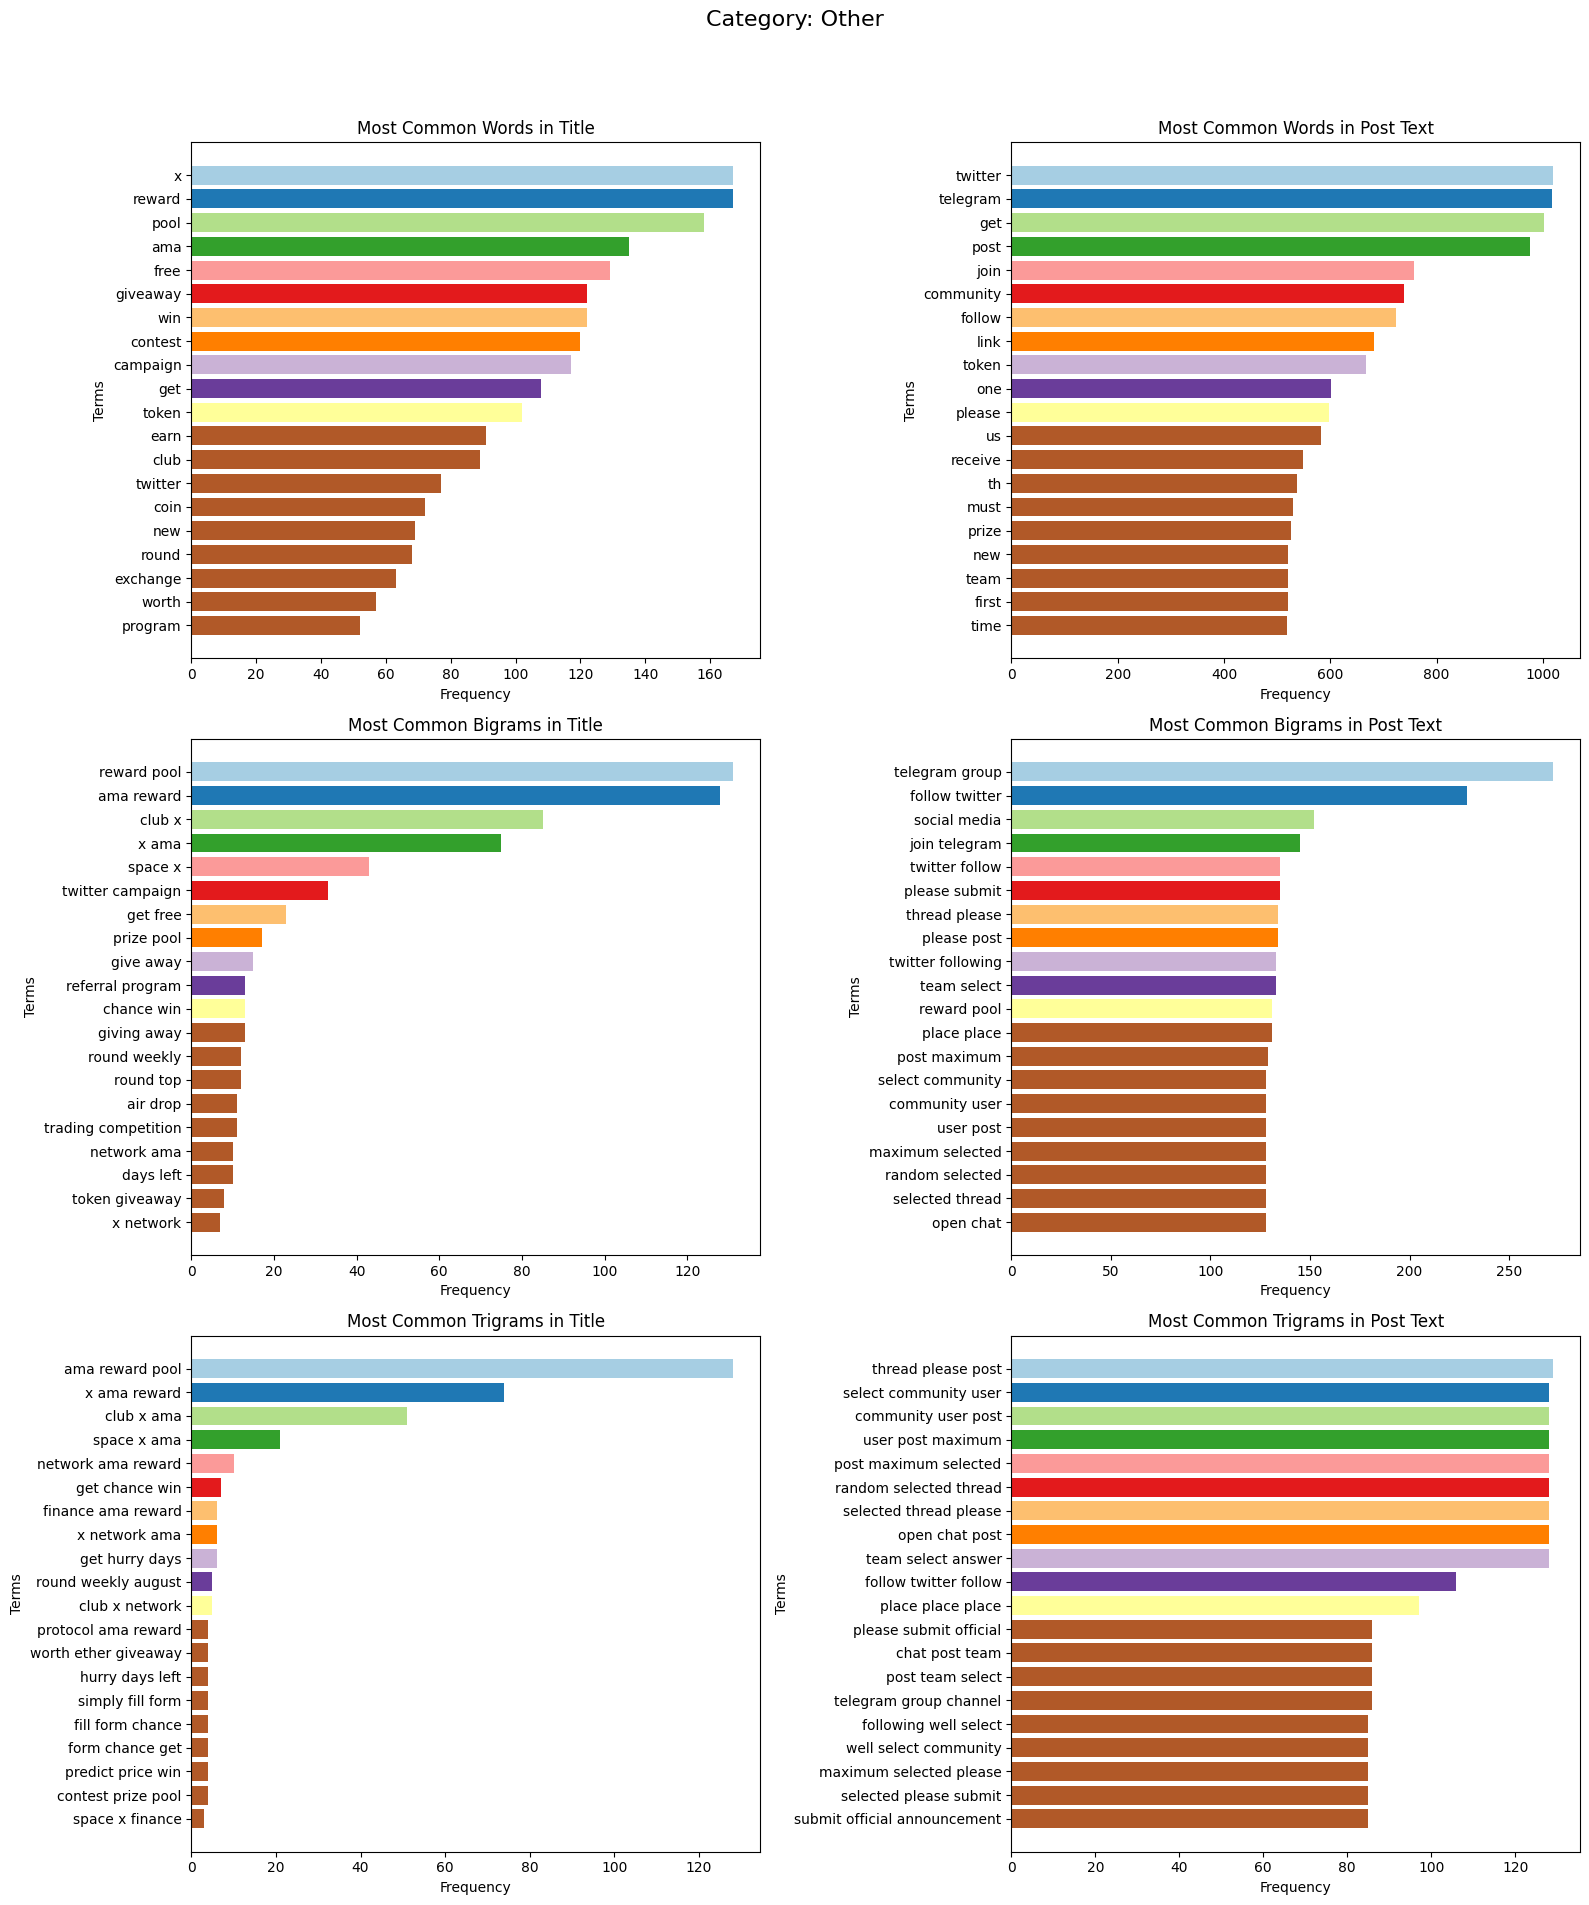

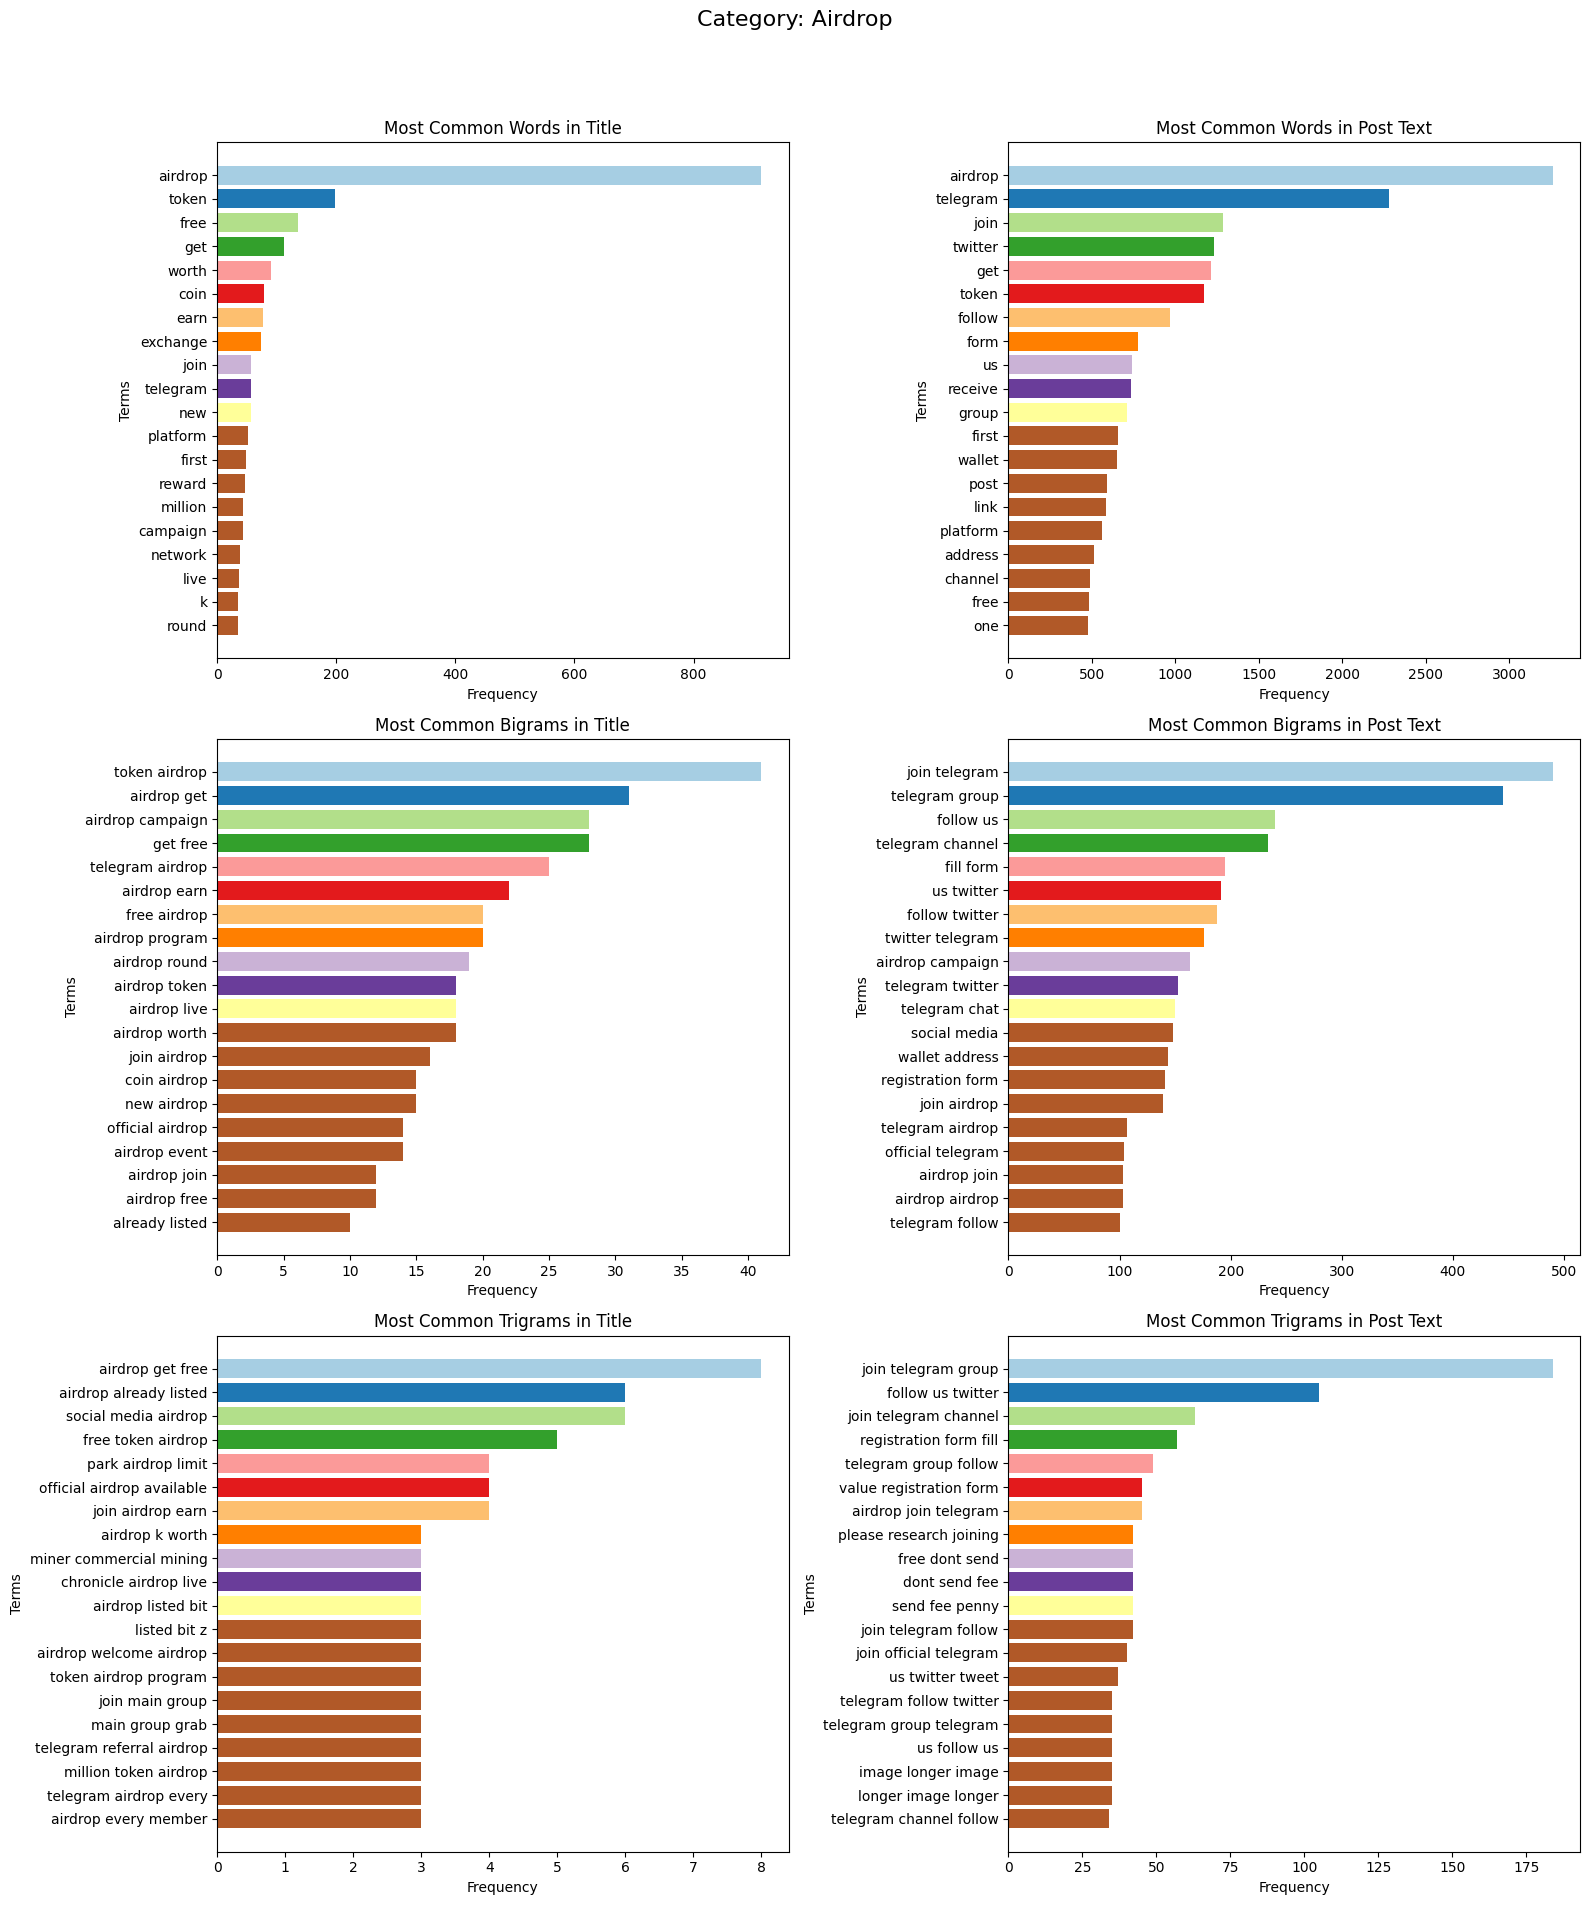

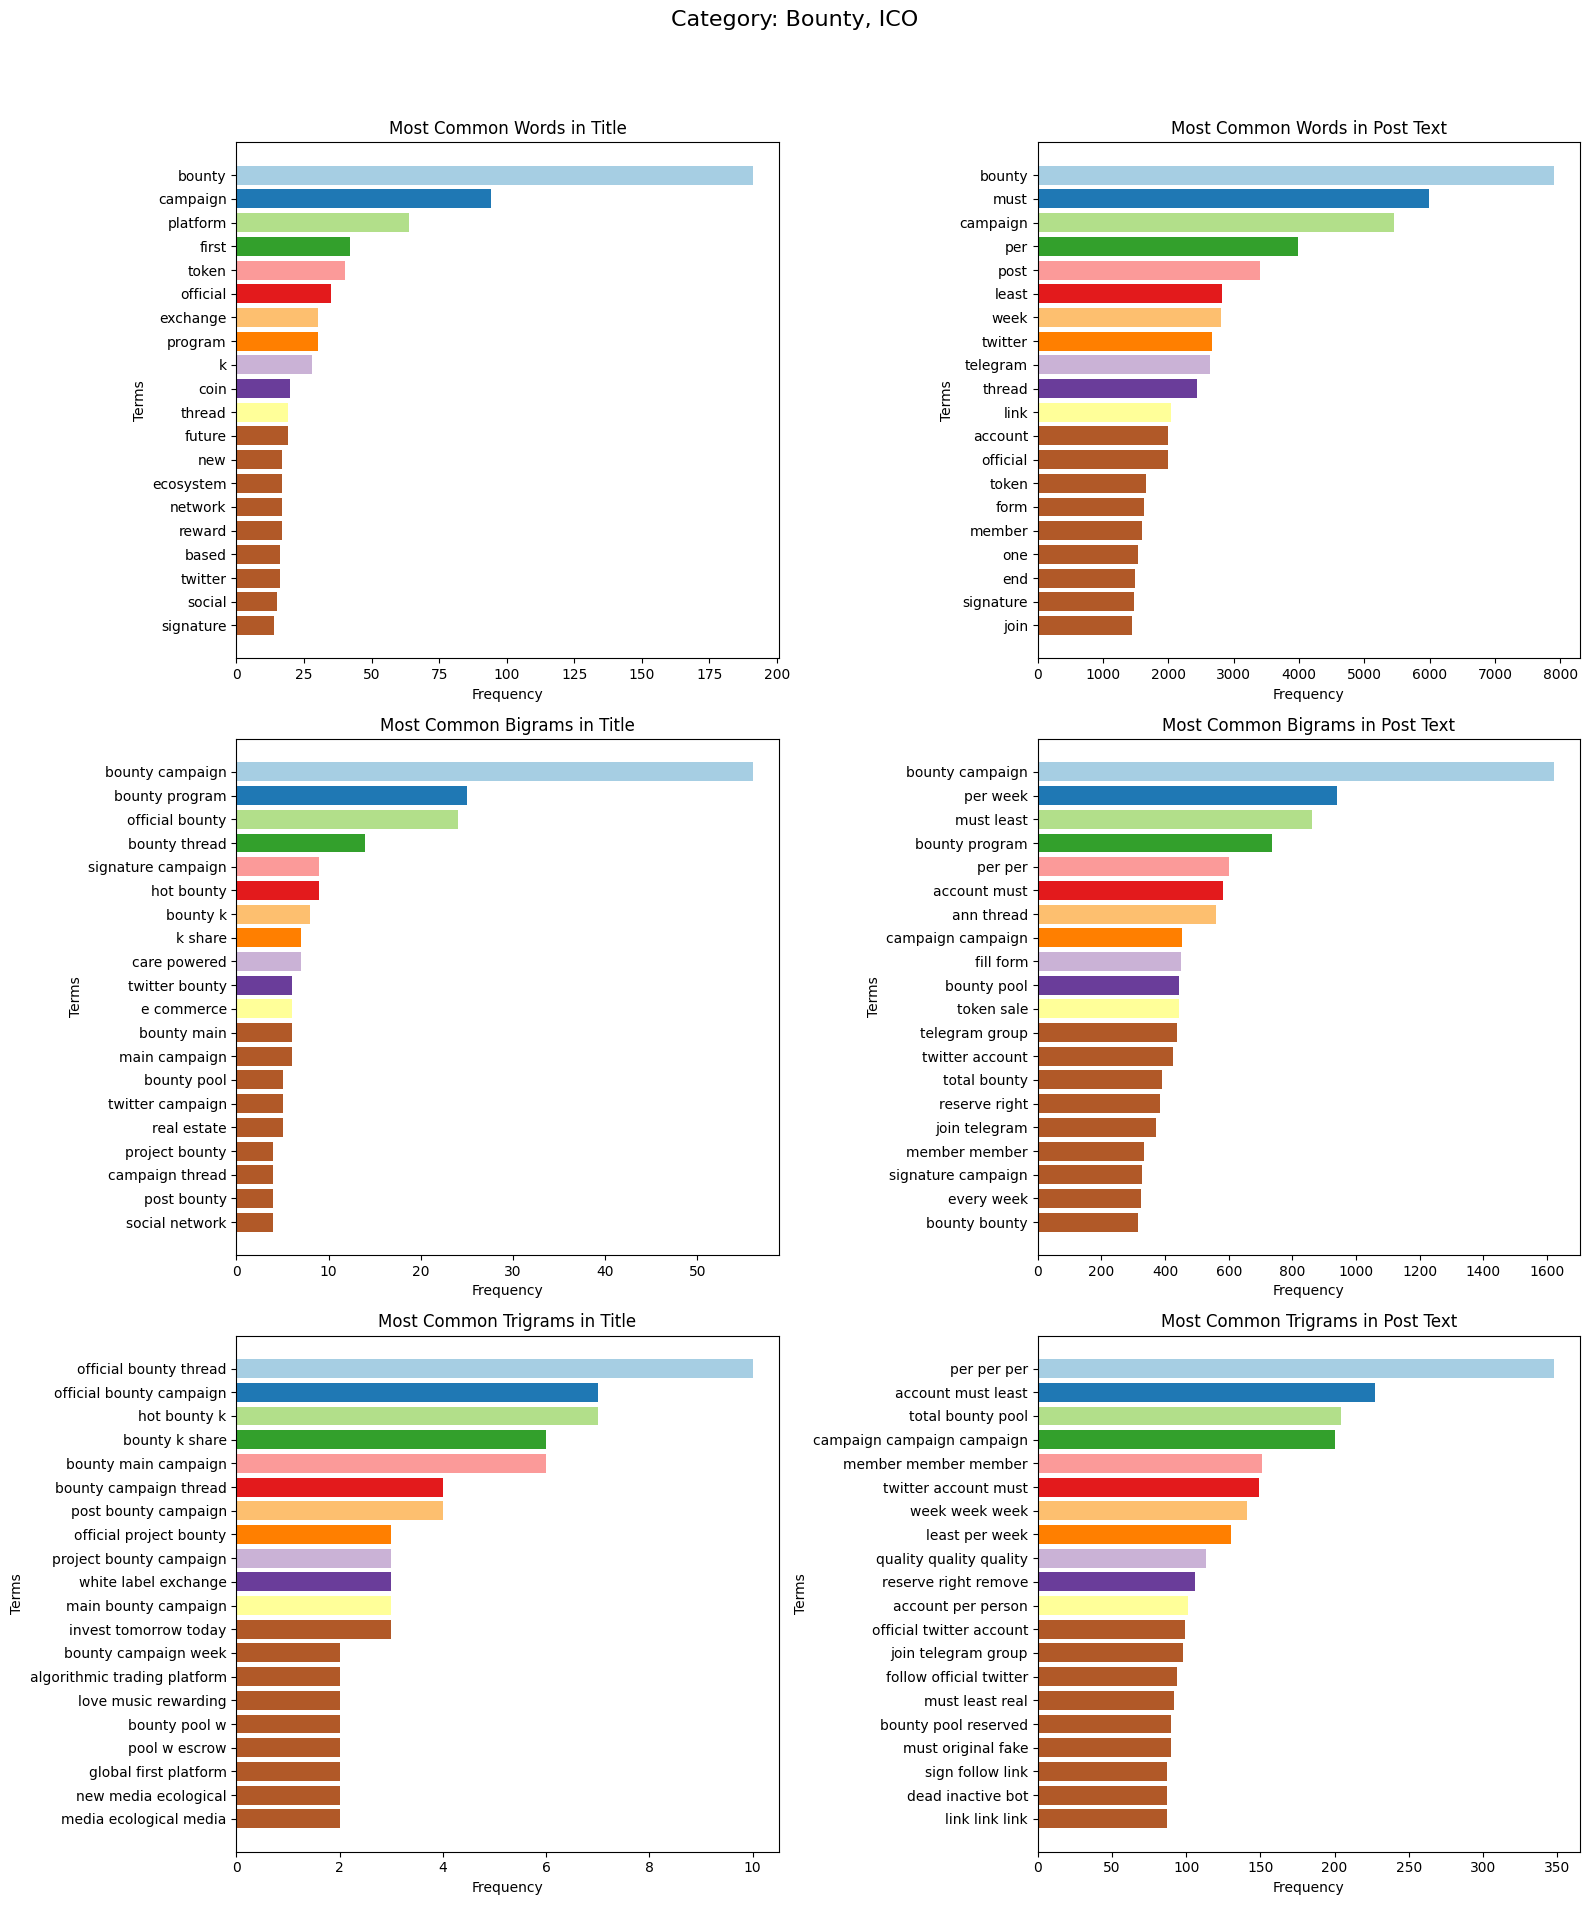

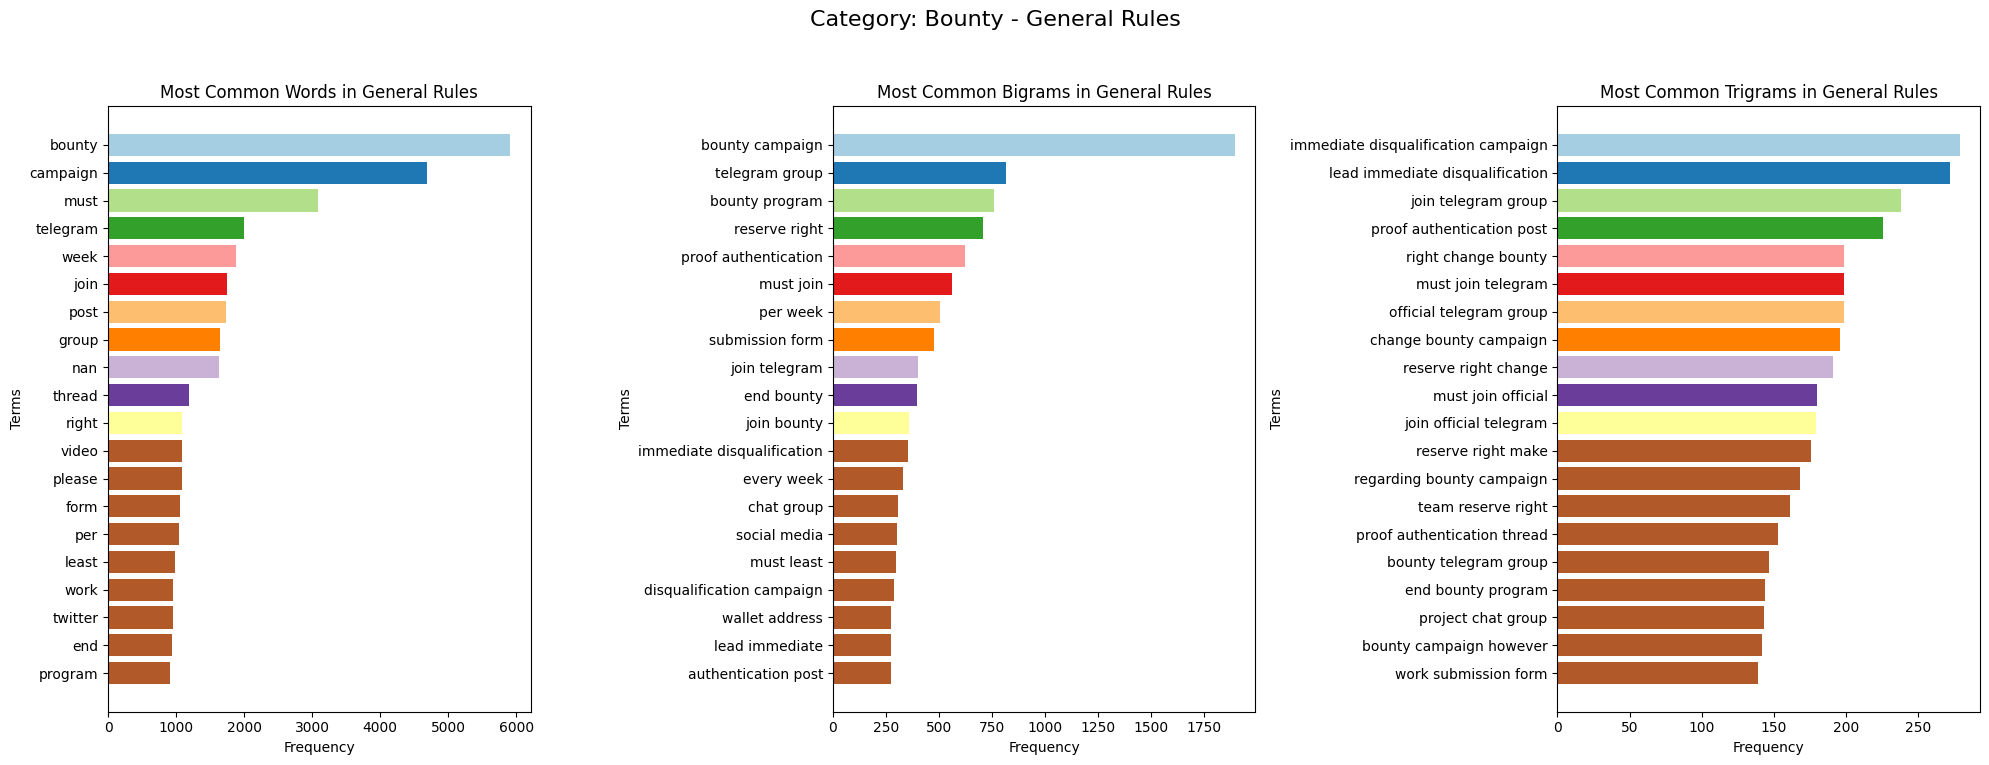

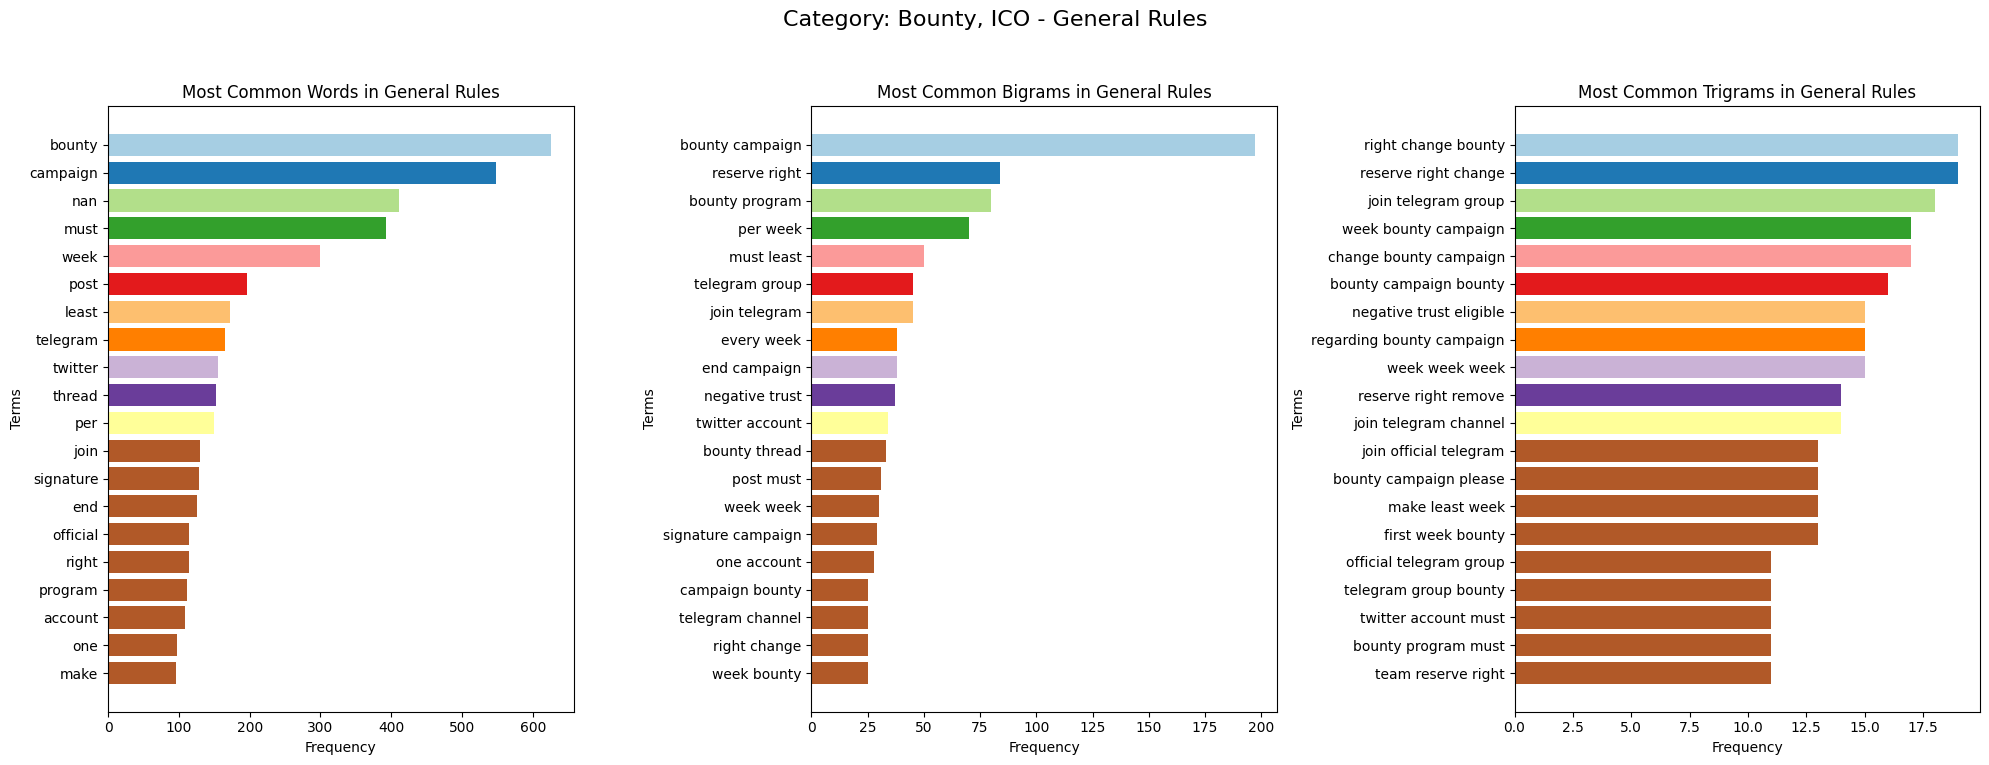

In [ ]:
# Create subplots for each category
for category in top_categories:
    category_df = events_df[events_df['categories'] == category]
    
    # Flatten the list of tokens and count frequencies for clean_title
    all_clean_title_tokens = [token for sublist in category_df['clean_title_tokens'] for token in sublist]
    clean_title_word_freq = Counter(all_clean_title_tokens)
    most_common_clean_title_words = clean_title_word_freq.most_common(20)

    # Flatten the list of tokens and count frequencies for post_tex
    all_post_tex_tokens = [token for sublist in category_df['post_tex_tokens'] for token in sublist]
    post_tex_word_freq = Counter(all_post_tex_tokens)
    most_common_post_tex_words = post_tex_word_freq.most_common(20)

    # Find bigrams and trigrams for clean_title
    all_clean_title_bigrams = [bigram for sublist in category_df['clean_title_tokens'] for bigram in bigrams(sublist)]
    all_clean_title_trigrams = [trigram for sublist in category_df['clean_title_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for clean_title
    clean_title_bigram_freq = Counter(all_clean_title_bigrams)
    clean_title_trigram_freq = Counter(all_clean_title_trigrams)
    most_common_clean_title_bigrams = clean_title_bigram_freq.most_common(20)
    most_common_clean_title_trigrams = clean_title_trigram_freq.most_common(20)

    # Find bigrams and trigrams for post_tex
    all_post_tex_bigrams = [bigram for sublist in category_df['post_tex_tokens'] for bigram in bigrams(sublist)]
    all_post_tex_trigrams = [trigram for sublist in category_df['post_tex_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for post_tex
    post_tex_bigram_freq = Counter(all_post_tex_bigrams)
    post_tex_trigram_freq = Counter(all_post_tex_trigrams)
    most_common_post_tex_bigrams = post_tex_bigram_freq.most_common(20)
    most_common_post_tex_trigrams = post_tex_trigram_freq.most_common(20)

    # Create subplots for the current category
    fig, axes = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(f'Category: {category}', fontsize=16)

    # Plot most common words
    plot_freq_distribution(axes[0, 0], most_common_clean_title_words, 'Most Common Words in Title')
    plot_freq_distribution(axes[0, 1], most_common_post_tex_words, 'Most Common Words in Post Text')

    # Plot most common bigrams
    plot_freq_distribution(axes[1, 0], most_common_clean_title_bigrams, 'Most Common Bigrams in Title')
    plot_freq_distribution(axes[1, 1], most_common_post_tex_bigrams, 'Most Common Bigrams in Post Text')

    # Plot most common trigrams
    plot_freq_distribution(axes[2, 0], most_common_clean_title_trigrams, 'Most Common Trigrams in Title')
    plot_freq_distribution(axes[2, 1], most_common_post_tex_trigrams, 'Most Common Trigrams in Post Text')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Specific analysis for Bounty and ICO categories for general_rules
for category in ['Bounty', 'Bounty, ICO']:
    category_df = events_df[events_df['categories'] == category]
    
    # Flatten the list of tokens and count frequencies for general_rules
    all_general_rules_tokens = [token for sublist in category_df['general_rules_tokens'] for token in sublist]
    general_rules_word_freq = Counter(all_general_rules_tokens)
    most_common_general_rules_words = general_rules_word_freq.most_common(20)

    # Find bigrams and trigrams for general_rules
    all_general_rules_bigrams = [bigram for sublist in category_df['general_rules_tokens'] for bigram in bigrams(sublist)]
    all_general_rules_trigrams = [trigram for sublist in category_df['general_rules_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for general_rules
    general_rules_bigram_freq = Counter(all_general_rules_bigrams)
    general_rules_trigram_freq = Counter(all_general_rules_trigrams)
    most_common_general_rules_bigrams = general_rules_bigram_freq.most_common(20)
    most_common_general_rules_trigrams = general_rules_trigram_freq.most_common(20)

    # Create subplots for the current category
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(f'Category: {category} - General Rules', fontsize=16)

    # Plot most common words in general_rules
    plot_freq_distribution(axes[0], most_common_general_rules_words, 'Most Common Words in General Rules')

    # Plot most common bigrams in general_rules
    plot_freq_distribution(axes[1], most_common_general_rules_bigrams, 'Most Common Bigrams in General Rules')

    # Plot most common trigrams in general_rules
    plot_freq_distribution(axes[2], most_common_general_rules_trigrams, 'Most Common Trigrams in General Rules')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### TD-IDF

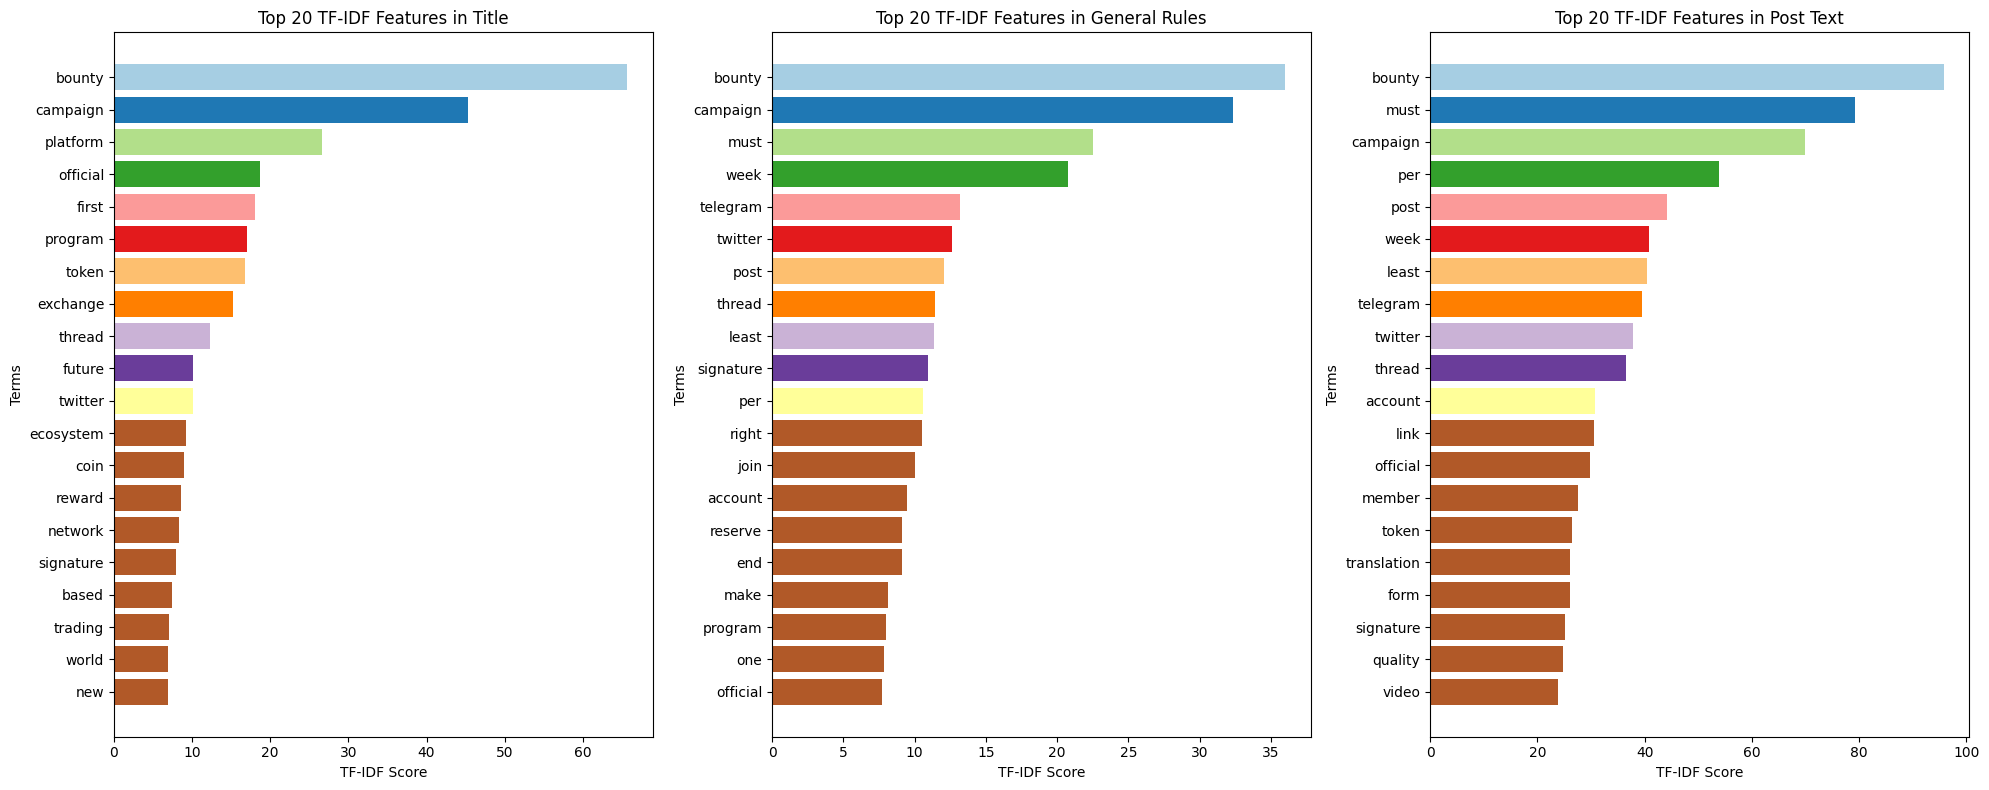

In [ ]:
# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Get top 5 categories
top_categories = events_df['categories'].value_counts().nlargest(5).index

# Function to get top n TF-IDF scores
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
    sorted_indices = tfidf_matrix.sum(axis=0).A1.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], tfidf_matrix[:, i].sum()) for i in sorted_indices]
    return top_features

# Function to plot TF-IDF distribution
def plot_tfidf_distribution(ax, tfidf_features, title):
    labels, values = zip(*tfidf_features)
    ax.barh(labels, values, color=plt.cm.Paired(range(len(tfidf_features))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Terms')
    
# Compute TF-IDF for clean_title
tfidf_vectorizer_ct = TfidfVectorizer()
tfidf_matrix_ct = tfidf_vectorizer_ct.fit_transform(category_df['clean_title_tokens'])
feature_names_ct = tfidf_vectorizer_ct.get_feature_names_out()
top_tfidf_features_ct = get_top_tfidf_features(tfidf_matrix_ct, feature_names_ct)

# Compute TF-IDF for clean_general_rules
tfidf_vectorizer_gr = TfidfVectorizer()
tfidf_matrix_gr = tfidf_vectorizer_gr.fit_transform(category_df['general_rules_tokens'])
feature_names_gr = tfidf_vectorizer_gr.get_feature_names_out()
top_tfidf_features_gr = get_top_tfidf_features(tfidf_matrix_gr, feature_names_gr)

    
# Compute TF-IDF for post_tex
tfidf_vectorizer_pt = TfidfVectorizer()
tfidf_matrix_pt = tfidf_vectorizer_pt.fit_transform(category_df['post_tex_tokens'])
feature_names_pt = tfidf_vectorizer_pt.get_feature_names_out()
top_tfidf_features_pt = get_top_tfidf_features(tfidf_matrix_pt, feature_names_pt)


# Plot TF-IDF scores in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot for clean_title
plot_tfidf_distribution(axes[0], top_tfidf_features_ct, 'Top 20 TF-IDF Features in Title')

# Plot for general_rules
plot_tfidf_distribution(axes[1], top_tfidf_features_gr, 'Top 20 TF-IDF Features in General Rules')

# Plot for post_tex
plot_tfidf_distribution(axes[2], top_tfidf_features_pt, 'Top 20 TF-IDF Features in Post Text')

# Adjust layout
plt.tight_layout()
plt.show()




### By Category

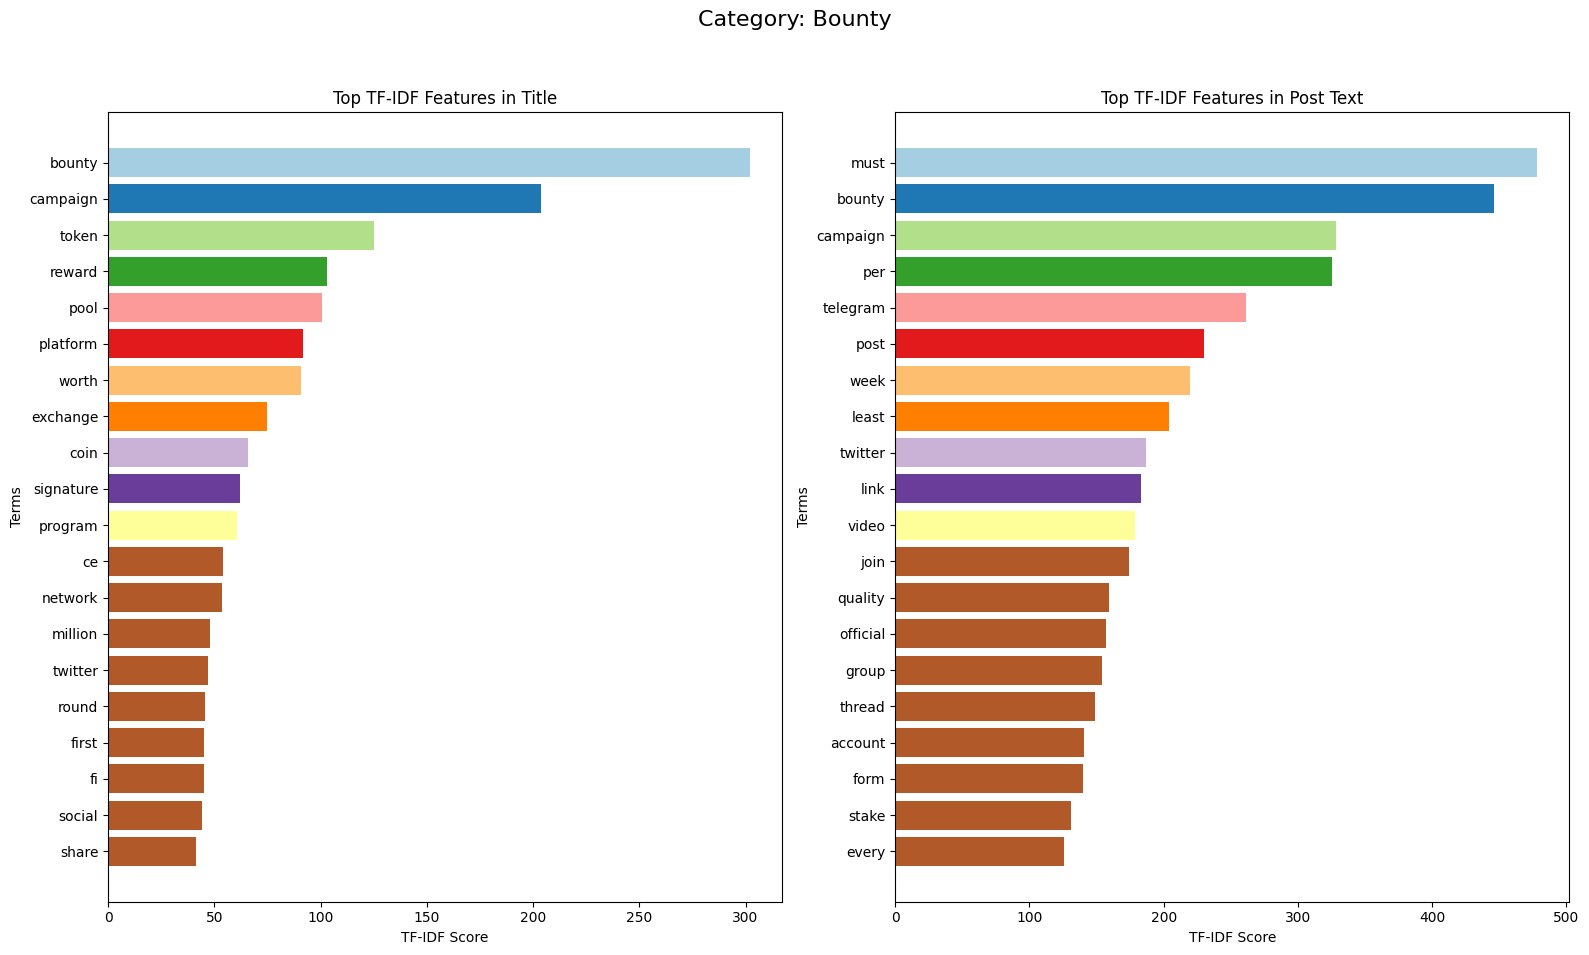

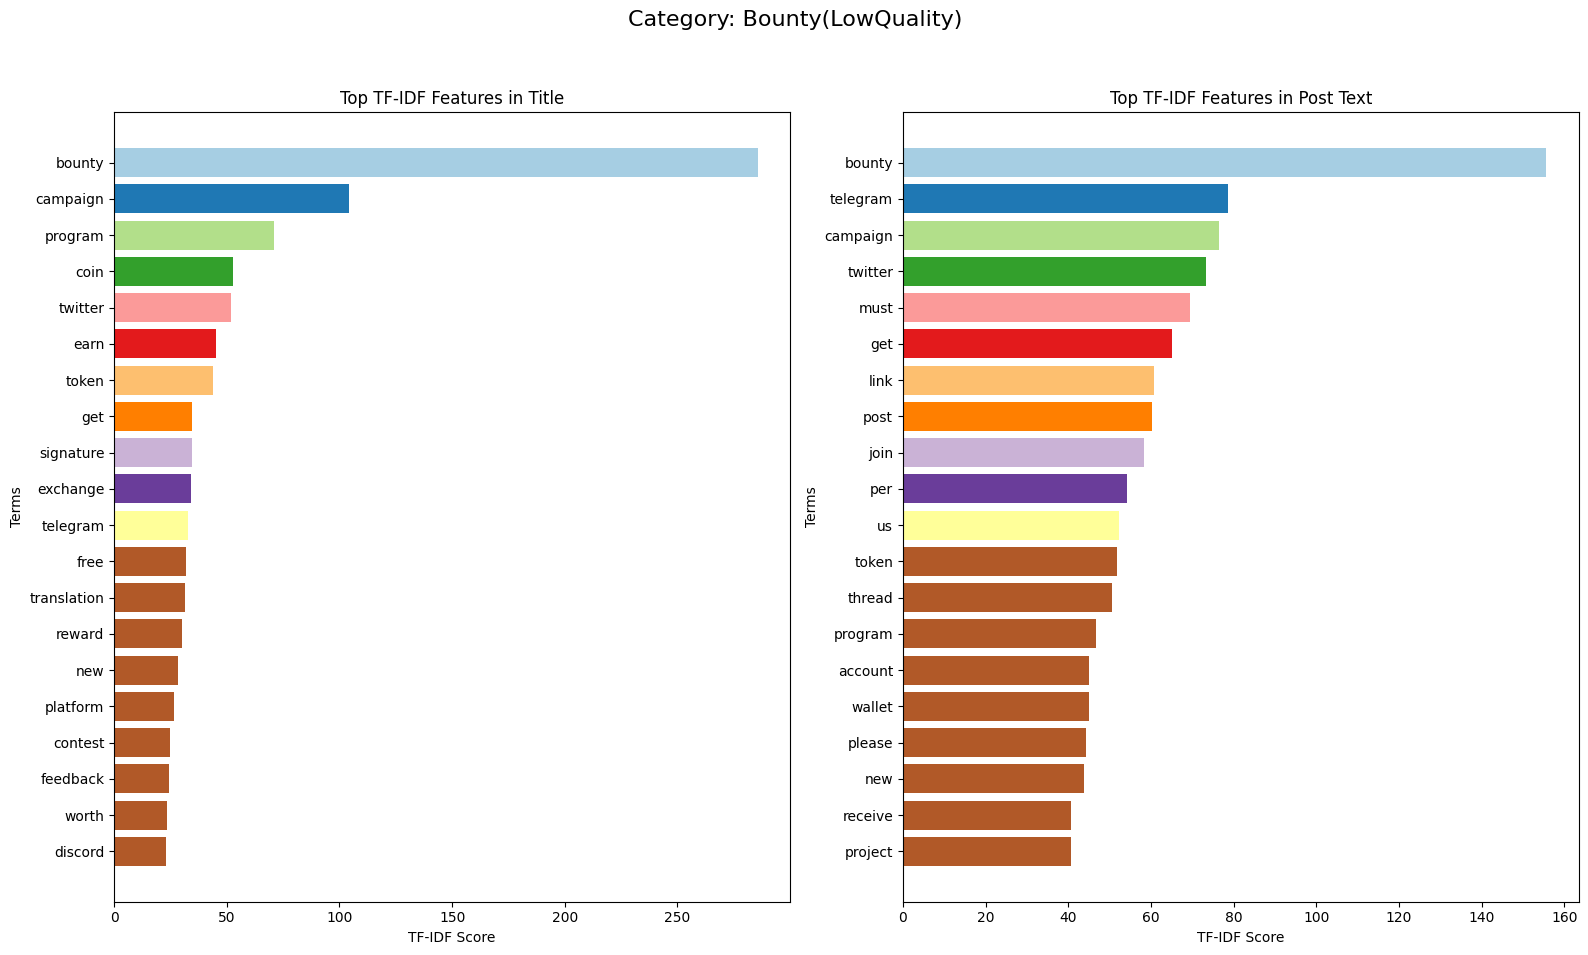

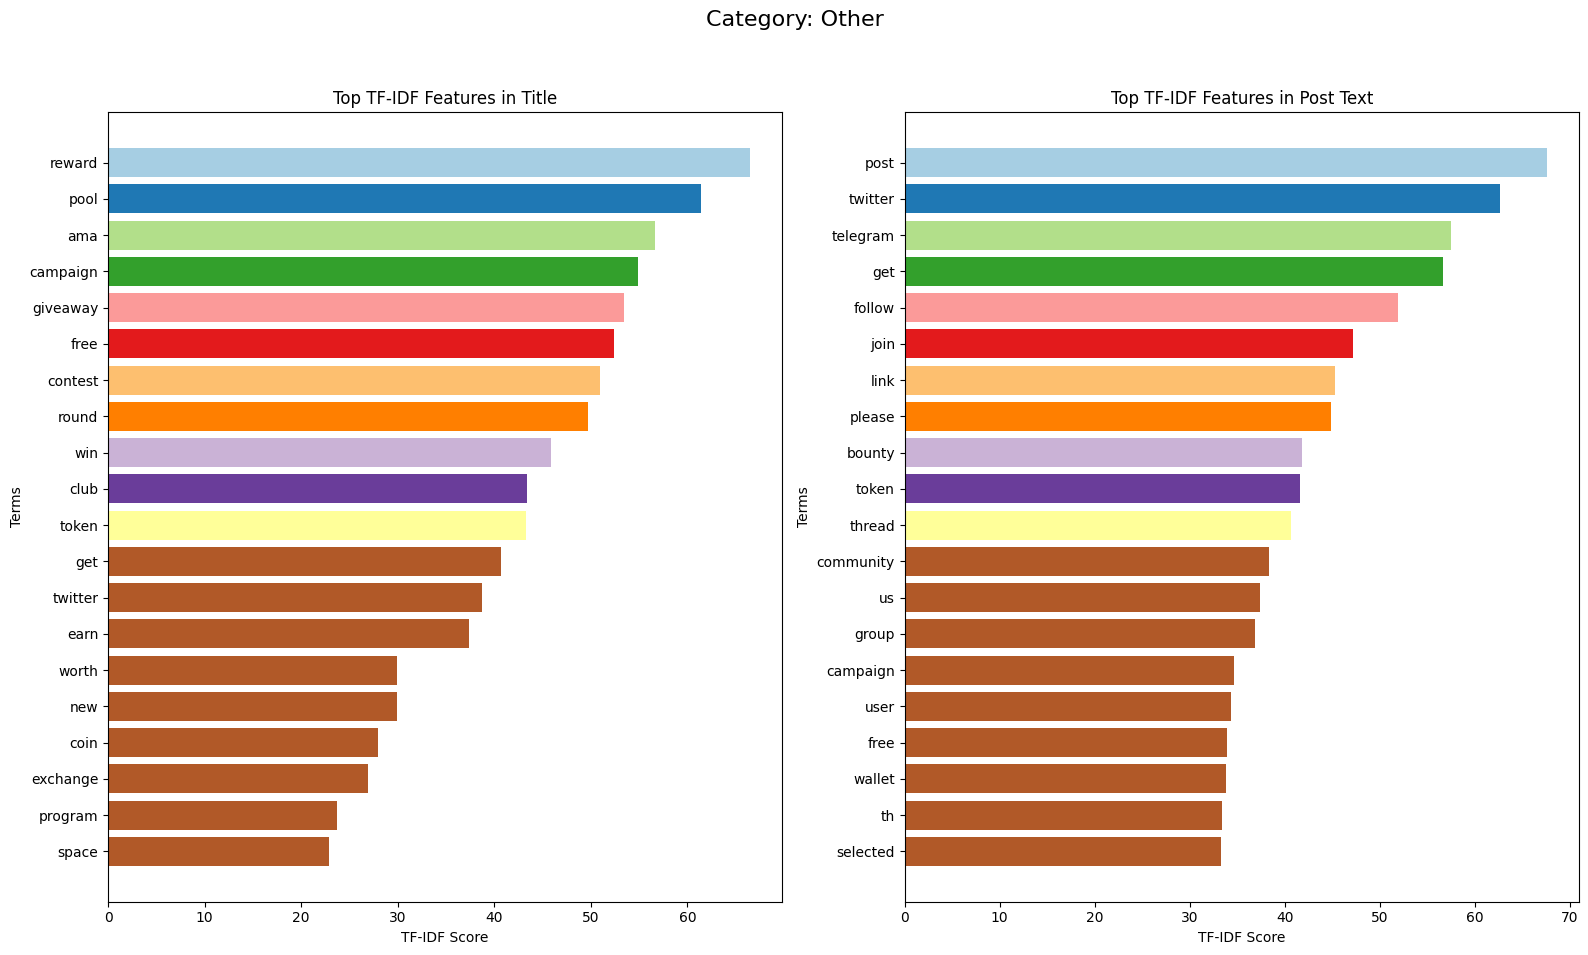

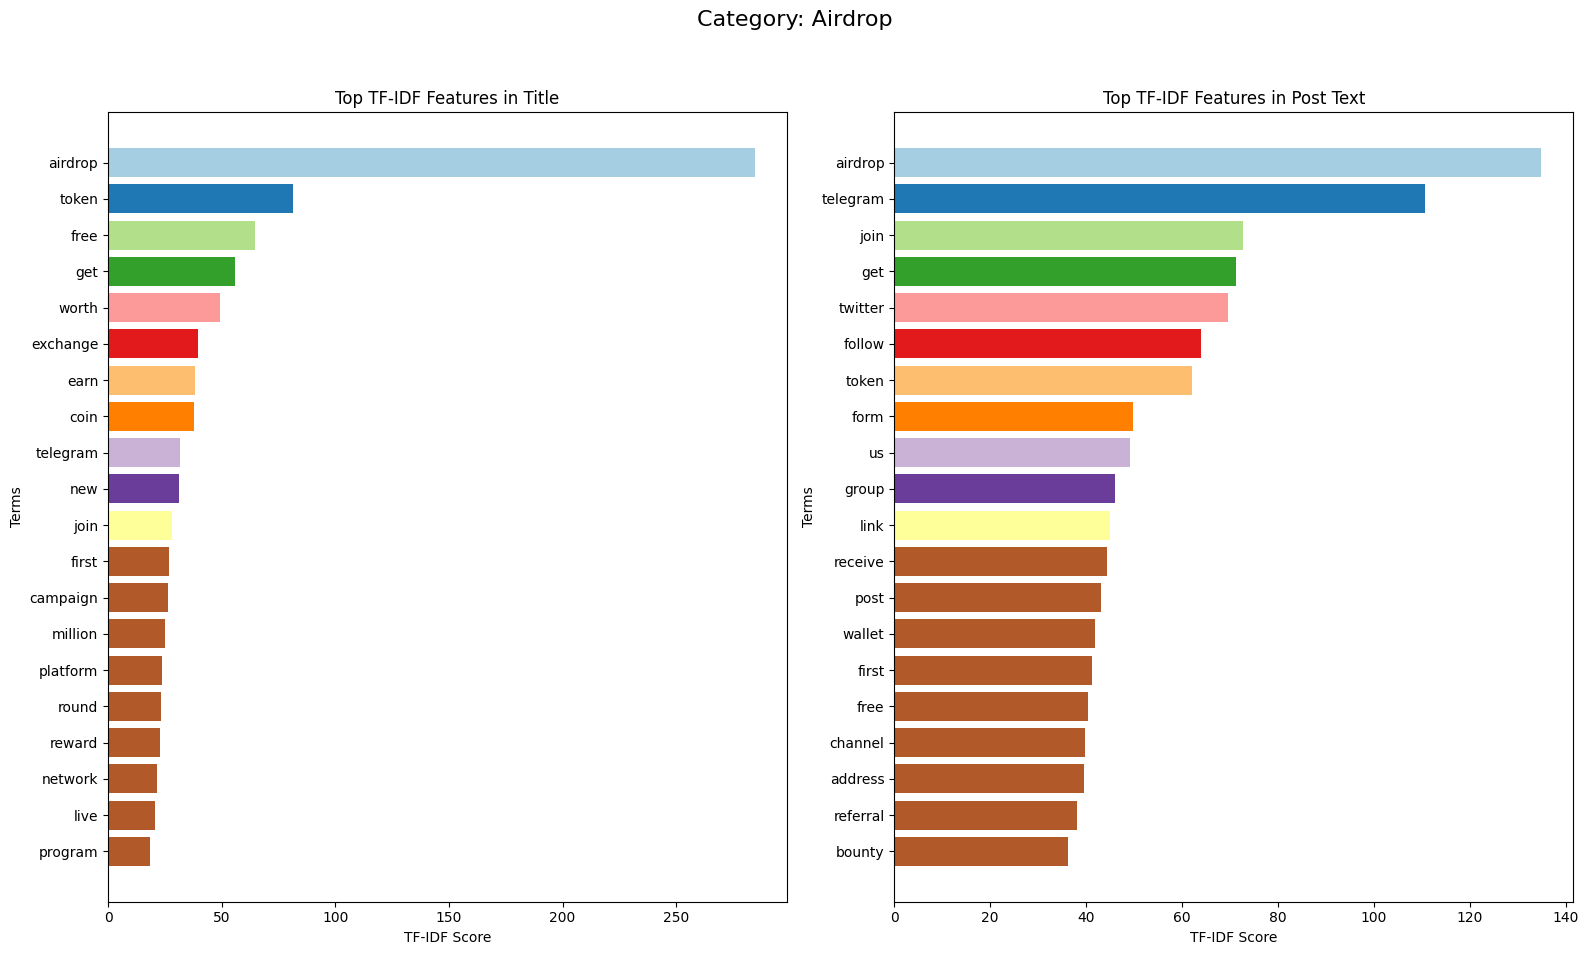

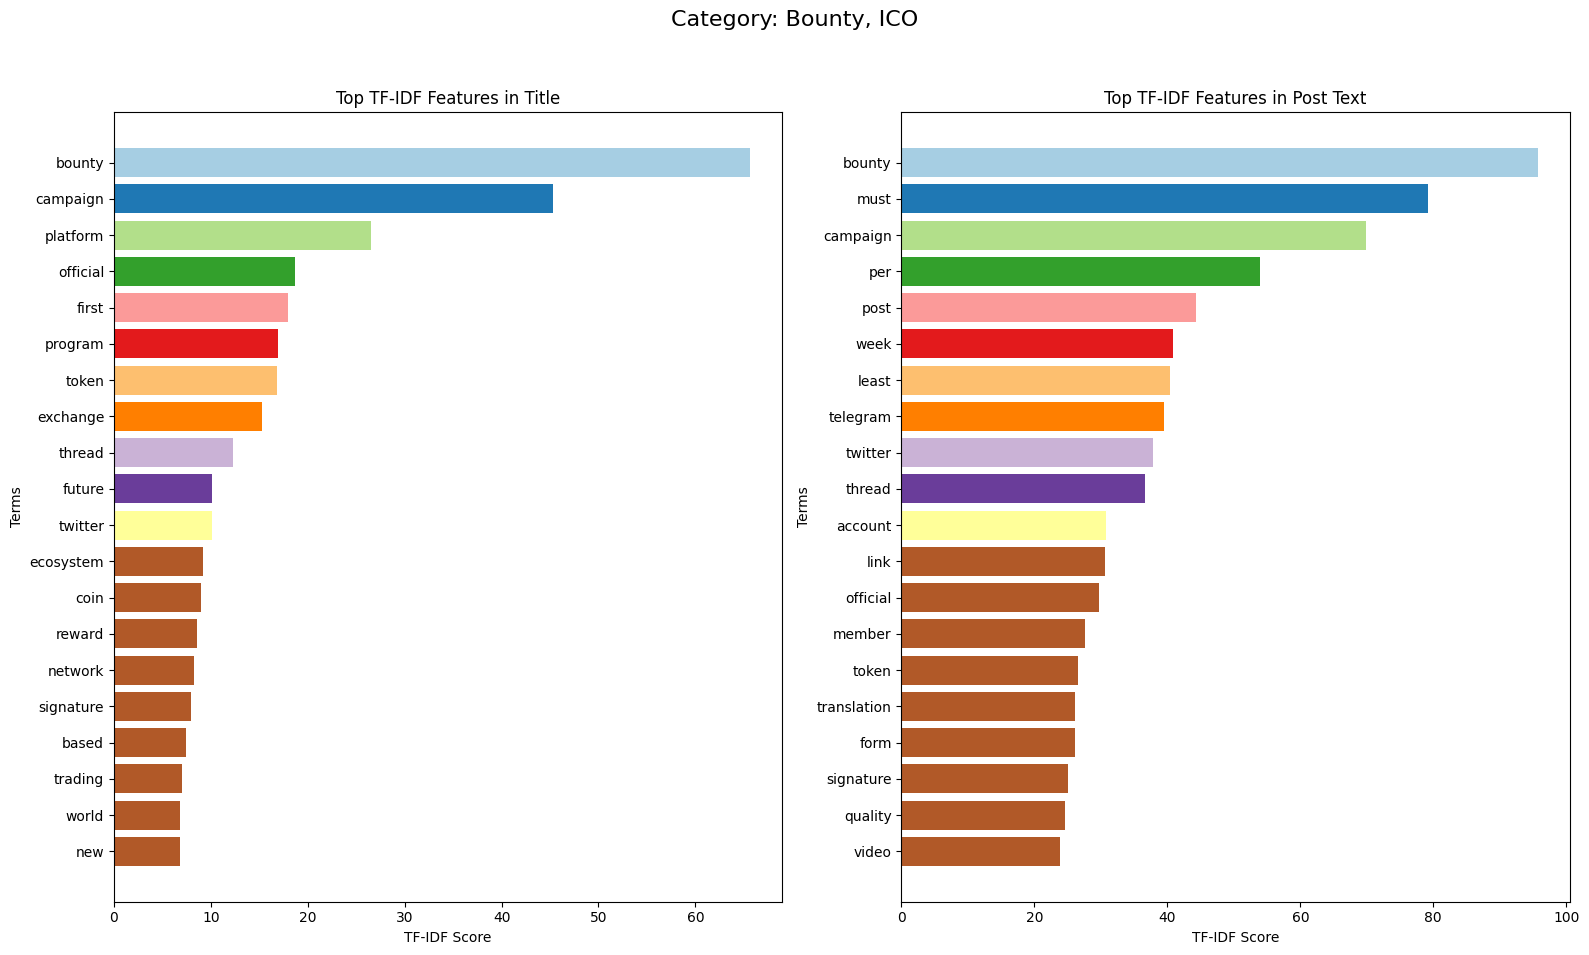

/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules'] = category_df['general_rules'].astype(str)
/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)


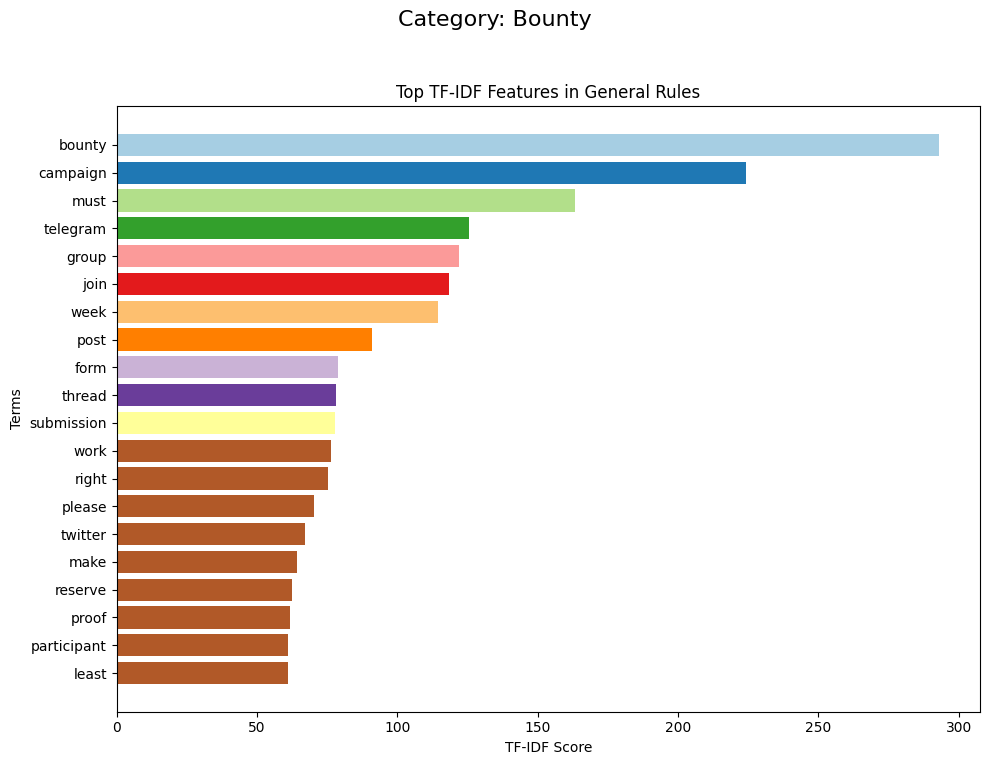

/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules'] = category_df['general_rules'].astype(str)
/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)


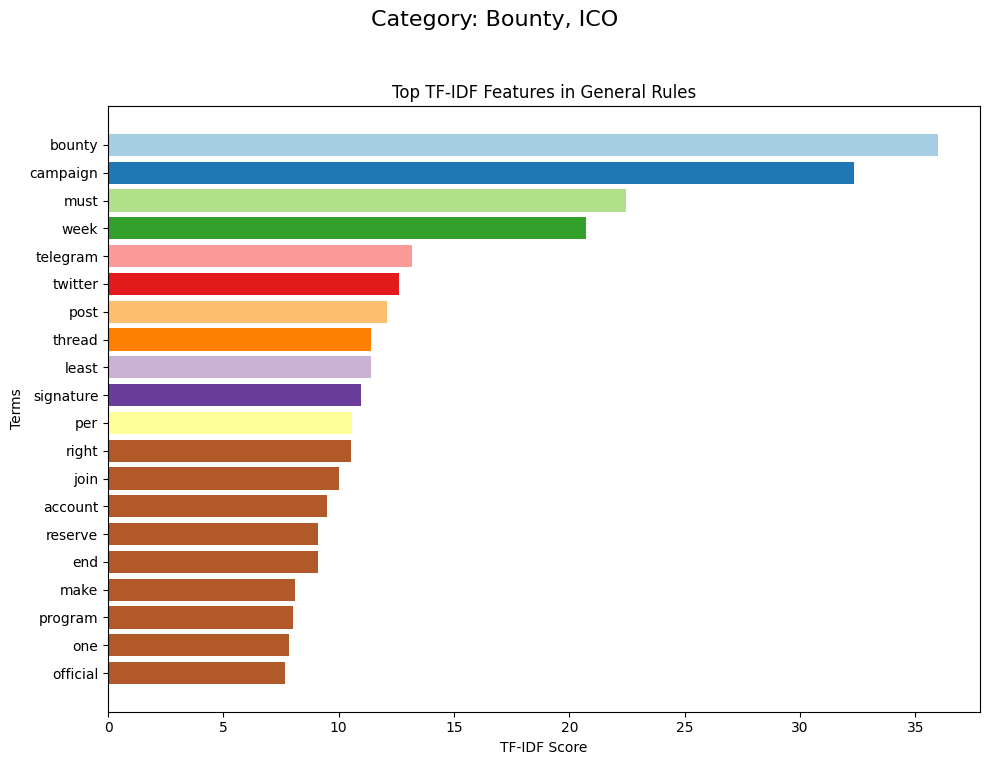

In [ ]:
# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Get top 5 categories
top_categories = events_df['categories'].value_counts().nlargest(5).index

# Function to get top n TF-IDF scores
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
    sorted_indices = tfidf_matrix.sum(axis=0).A1.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], tfidf_matrix[:, i].sum()) for i in sorted_indices]
    return top_features

# Function to plot TF-IDF distribution
def plot_tfidf_distribution(ax, tfidf_features, title):
    labels, values = zip(*tfidf_features)
    ax.barh(labels, values, color=plt.cm.Paired(range(len(tfidf_features))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Terms')

# Create subplots for each category
for category in top_categories:
    category_df = events_df[events_df['categories'] == category]
    
    # Compute TF-IDF for clean_title
    tfidf_vectorizer_ct = TfidfVectorizer()
    tfidf_matrix_ct = tfidf_vectorizer_ct.fit_transform(category_df['clean_title_tokens'])
    feature_names_ct = tfidf_vectorizer_ct.get_feature_names_out()
    top_tfidf_features_ct = get_top_tfidf_features(tfidf_matrix_ct, feature_names_ct)
    
    # Compute TF-IDF for post_tex
    tfidf_vectorizer_pt = TfidfVectorizer()
    tfidf_matrix_pt = tfidf_vectorizer_pt.fit_transform(category_df['post_tex_tokens'])
    feature_names_pt = tfidf_vectorizer_pt.get_feature_names_out()
    top_tfidf_features_pt = get_top_tfidf_features(tfidf_matrix_pt, feature_names_pt)
    
    # Create subplots for the current category
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(axes[0], top_tfidf_features_ct, 'Top TF-IDF Features in Title')
    plot_tfidf_distribution(axes[1], top_tfidf_features_pt, 'Top TF-IDF Features in Post Text')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Specific analysis for Bounty and Bounty, ICO categories for general_rules
for category in ['Bounty', 'Bounty, ICO']:
    category_df = events_df[events_df['categories'] == category]
    
    # Ensure 'general_rules' column is treated as string
    category_df['general_rules'] = category_df['general_rules'].astype(str)
    category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)
    
    # Compute TF-IDF for general_rules
    tfidf_vectorizer_gr = TfidfVectorizer()
    tfidf_matrix_gr = tfidf_vectorizer_gr.fit_transform(category_df['general_rules_tokens'])
    feature_names_gr = tfidf_vectorizer_gr.get_feature_names_out()
    top_tfidf_features_gr = get_top_tfidf_features(tfidf_matrix_gr, feature_names_gr)
    
    # Create subplot for the current category
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(ax, top_tfidf_features_gr, 'Top TF-IDF Features in General Rules')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
